# Functional Comparison of ASN with WS and C. Elegans

This notebook generates 24 different ASN networks with 300 nodes, each of which has differing parameters (Average Path length, Wire Dispersion and Centroid Dispersion). 

We then find the average degree for each ASN network, and use that as 2k to generate corresponding grid-like, small-world and random Watts-Strogatz networks.

We also load a sample C. Elegans network for comparison.

In [1]:
# !jupyter notebook --version
# !python --version
# !conda --version
# # !jupyter trust RunTasksDifferentNetworks_MultipleNetworks.ipynb

In [1]:
cd

/suphys/aloe8475


In [2]:
cd "Documents/edamame"

/import/silo2/aloe8475/Documents/edamame


In [3]:
from scipy.io import loadmat, savemat
from scipy.stats import kurtosis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm.notebook import tqdm_notebook
import os
import edamame.core.wires as wires
from random import choice
import warnings
from IPython.core.debugger import set_trace
import nct
import bct

#warnings.filterwarnings('ignore')

## Functions:

In [4]:
import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)

In [5]:
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [6]:
# this_seed2=700
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [7]:
#Select Largest Components
def select_largest_component_new(wires_dict):
    """
    Find and select largest connected component of the original graph G.
    Throws away unconnected components and updates all the keys in wires_dict 
    """
#     def connected_component_subgraphs(G):
#         for c in nx.connected_components(G):
#             yield G.subgraph(c)
    
    wires_dict['G'] = max(connected_component_subgraphs(wires_dict['G']), key=len)
#     set_trace()
    nw = len(wires_dict['G'].nodes())
    nj = len(wires_dict['G'].edges())   
    
    logging.info("The largest component has %5d nodes and %6d edges", nw, nj)

    # Replace values in the dictionary
    wires_dict['number_of_wires']     = nw
    wires_dict['number_of_junctions'] = nj
    wires_dict['xa'] = wires_dict['xa'][wires_dict['G'].nodes()] 
    wires_dict['ya'] = wires_dict['ya'][wires_dict['G'].nodes()] 
    wires_dict['xb'] = wires_dict['xb'][wires_dict['G'].nodes()] 
    wires_dict['yb'] = wires_dict['yb'][wires_dict['G'].nodes()]
    wires_dict['xc'] = wires_dict['xc'][wires_dict['G'].nodes()] 
    wires_dict['yc'] = wires_dict['yc'][wires_dict['G'].nodes()]
 
    # Keep old edge_list
    old_edge_list = [(ii, kk) for ii, kk in  zip(wires_dict['edge_list'][:, 0], wires_dict['edge_list'][:, 1])]
    # Remove old edge list
    wires_dict = wires.remove_key(wires_dict, 'edge_list') 
    # Save indices of intersections in the old graph
    ind_dict = {key:value for value,key in enumerate(old_edge_list)}
    new_edge_list = sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0])
    # Find intersection between the two sets
    inter = set(ind_dict).intersection(new_edge_list)
    # Retrieve edge indices/positions from the old list
    edges_idx = [ind_dict[idx] for idx in inter]
       
    # These have length equal to number of junctions -- only get the ones we need
    wires_dict['xi'] = wires_dict['xi'][edges_idx] 
    wires_dict['yi'] = wires_dict['yi'][edges_idx] 
    
    # Get contiguous numbering of nodes
    # Build node mapping 
    node_mapping    = {key:value for value, key in enumerate(sorted(wires_dict['G'].nodes()))}
    # This  step also renames edges list
    wires_dict['G'] =  nx.relabel_nodes(wires_dict['G'] , node_mapping)

    # Swap node vertices if vertex 0 is larger than vertex 1, then sort by first element
    wires_dict['edge_list'] = np.asarray(sorted([kk if kk[0] < kk[1] else (kk[1], kk[0]) for kk in wires_dict['G'].edges()], key=lambda x: x[0]))
    
    # Save adjacency matrix of new graph
    wires_dict = wires.remove_key(wires_dict, 'adj_matrix') 
    wires_dict = wires.generate_adj_matrix(wires_dict)

    wire_distances = wires.cdist(np.array([wires_dict['xc'], wires_dict['yc']]).T, np.array([wires_dict['xc'], wires_dict['yc']]).T, metric='euclidean')    
    wires_dict['wire_distances'] = wire_distances

    return wires_dict 

In [9]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

## Load Structural Connectivity

In [10]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


### Elegans

In [13]:
name='elegans_LinearTransformation.pkl'
print('Loading Elegans Networks')
file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
[Elegans] = pickle.load(file)

print('Loaded')

Loading Elegans Networks
Loaded


In [14]:
elegansGraph=Elegans['G']

In [15]:
#Small world calculated on C Elegans Matrix in smallworld.m in MATLAB
temp=loadmat(r'cElegans_smallworld.mat')
smallworld_elegans=temp['cElegansSW'][0]
del temp

### ASNs

In [9]:
cd "/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks"

/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks


In [11]:
# Small Worldness: 
# ------------------------------------
# CALCULATED IN MATLAB: smallworldness.m 
# found in C:\Users\aloe8475\Documents\PhD\GitHub\CODE\Analysis\Functional Connectivity\Functional Tasks
# ------------------------------------
temp=loadmat(r'300nwASN_multipleNetworks_smallworld.mat')
smallworld=temp['smallworld']
del temp

In [10]:
name='networks_LinearTransformation.pkl'
print('Loading Networks + Linear Transformation Results')
file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
[ASN300] = pickle.load(file)

print('Loaded')

Loading Networks + Linear Transformation Results
Loaded


In [11]:
ASN300

KeyboardInterrupt: 

# Task 1: Nonlinear  Transformation

In [13]:
#Regression
def NOKEVregression(target,absV): 
    inputx=np.vstack((np.ones(len(target)),absV)).T
    a1=np.linalg.lstsq(inputx,target)
    return a1

In [14]:
#Subgraph AdjMat

#Threshold by conductance - when tunnelling becomes appreciable (offResistance * 10)

def getOnGraph(network, this_TimeStamp = 0):
    edgeList = network.connectivity.edge_list
    adjMat = np.zeros((network.numOfWires, network.numOfWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = (1/network.junctionResistance[this_TimeStamp,:])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = (1/network.junctionResistance[this_TimeStamp,:])>1e-06#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    onGraph = nx.from_numpy_array(adjMat)
    onGraph=nx.DiGraph.to_undirected(onGraph)
    
    return onGraph

In [15]:
def getSubGraphComm(network, this_TimeStamp = 0):
    onGraph = getOnGraph(network, this_TimeStamp)
    components = [i for i in nx.connected_components(onGraph)]
    giant_component = components[np.argmax([len(i) for i in nx.connected_components(onGraph)])]
    nodes = list(giant_component)
    commMat = np.zeros((network.numOfWires, network.numOfWires))
    subComm = nx.communicability(onGraph.subgraph(giant_component))
    for i in nodes:
        for j in nodes:
            commMat[i,j] = subComm[i][j]
    return commMat

In [16]:
#Communicability + Current Matrices
def commCurr(sim):
    startTime=500
    timeSteps=50
    endTime=1500
    time_index=[startTime,endTime,timeSteps]#]len(sim.junctionResistance),timeSteps]
    currMat=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    nodesListFull=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    commu_Mat=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    new_currGraph=[None]*len(range(startTime,endTime,timeSteps))#startTime,len(sim.junctionResistance),timeSteps))
    count = 0
    for i in tqdm(range(startTime,endTime,timeSteps)):#startTime,len(sim.junctionResistance),timeSteps)): #for each timestep
        currMat[count] = np.zeros((sim.numOfWires,sim.numOfWires))
        edgeList = sim.connectivity.edge_list
        currMat[count][edgeList[:,0], edgeList[:,1]] = sim.junctionVoltage[i,:]/sim.junctionResistance[i,:] #-1,:
        currMat[count] = currMat[count] + currMat[count].T
        currGraph = nx.from_numpy_array(currMat[count])
        subGraph = getOnGraph(sim, this_TimeStamp=i)
        commu_Mat[count]=getSubGraphComm(sim, this_TimeStamp=i)
        
        components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

        max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
        currGraph = nx.subgraph(currGraph, components[max_ind])
        new_currGraph[count] = currGraph
        currMat[count] = np.array(nx.adjacency_matrix(new_currGraph[count]).todense())

#         commu = nx.communicability(new_currGraph[count])
#         commu_Edges[count]=commu
#         subSize = len(currGraph)
        nodesList=list(currGraph.nodes)
        nodesListFull[count]=nodesList

#         commu_Mat[count] = np.array([commu[k][j] for k in nodesList for j in nodesList]).reshape(subSize,subSize)
        count = count+1
        
    return nodesListFull,commu_Mat, currMat, new_currGraph, time_index

## ASN Networks:

In [17]:
# onAmp=[[] for i in range(len(ASN300))]
# shortestPath=[[None]*10 for i in range(len(ASN300))]
# for i in tqdm(range(len(ASN300))):
#     for j in range(len(ASN300[i])):
#         temp=getFarthestPairing(ASN300[i][j]['adj_matrix'])
#         shortestPath[i][j]=nx.shortest_path_length(ASN300[i][j]['G'],temp[0],temp[1])
#         onAmp[i].append(shortestPath[i][j]/5) #need to justify divide by 5 or come up with some other way
#         ASN300[i][j]['sp_amp']=onAmp[i][j]
#         ASN300[i][j]['Graph Theory']['Shortest Path']=shortestPath[i][j]

In [20]:
def nonlineartrans(ASN300,onAmp,i,j,nodesList,stimulus,acc):
    
    dt = 1e-2
    f=0.5
    Time=5
    period=1/f
   #Instantiate Variables    
    print('Running Linear Transformation Simulations')
    print(i)
    print(j)
    dt = 1e-2
    f=0.5
    Time=5

    #Choose Electrode Pattern
    stimulus[0][i].append((stimulus__(biasType='AC',onAmp=onAmp,TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1][i].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

    #Initialise Output Variables
    period=[]
    TimeVector=[]
    voltage=[]
    conductance=[]
    switches=[]
    results_ASN=[]
    #Run Simulations
    print('Parameter ' + str(i+1), ', Network ' + str(j+1))
    #Run Simulations
#     results=[]
    # Connectivity=connectivity__('700nw_14533junctions.mat')
    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item
#     set_trace()
    results_ASN=runSim(connectivity__(wires_dict=ASN300[i][j]),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmp, biasType='AC',f=f,junctionMode='tunneling')
    #wires_dict=newNetworkTest[chosenNetwork])
    results_ASN.frequency=f
    results_ASN.dt=0.001
    print('Saving 10 Simulations for Network ' +str(i+1) + ' Parameter ' + str(j+1))
    results={'JunctionConductance':results_ASN.junctionConductance[-1],'JunctionVoltage':results_ASN.junctionVoltage[-1],'WireVoltage':results_ASN.wireVoltage[-1],'Switch':results_ASN.junctionSwitch[-1],'Source':results_ASN.sources[0],'Drain':results_ASN.drains[0]}
    compressed_pickle(results,'../../../Data/Functional Connectivity/NWN Results/NWN_NLT_Simulation_2VAmp_'+str(i+1)+'_'+str(j+1)+'.pkl')
#     print('Saved')
    period=1/f  

    print('Regressing Parameter ' + str(i+1), ', Network ' + str(j+1))
    TimeVector=results_ASN.TimeVector
    voltage=results_ASN.wireVoltage
    conductance=results_ASN.conductance
    switches=results_ASN.junctionSwitch

    target1= (onAmp * (-np.sign(TimeVector % period - period/2)))
#             target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
#             target3[j] = (onAmp[i]/period * (TimeVector % period))
#             target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))

    if len(ASN300[i][j]['G']) >= 250:
        nodesList[i][j]=[50,100,150,200,250,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)
    elif len(ASN300[i][j]['G']) >= 200 and len(ASN300[i][j]['G']) < 250:
        nodesList[i][j]=[50,100,150,200,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(ASN300[i][j]['G']) >= 150 and len(ASN300[i][j]['G']) < 200:
        nodesList[i][j]=[50,100,150,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
    elif len(ASN300[i][j]['G']) >= 100 and len(ASN300[i][j]['G']) < 150:
        nodesList[i][j]=[50,100,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)
    
    nwSqu =[None]*len(nodesList[i][j])
    countK=0

    for k in nodesList[i][j]: #loop through sets of nodes for regression
        print('Running Regression: ' + str(k) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_ASN,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
        nwSqu[countK]=ResultSqu['accuracy']
        ASN300[i][j]['Accuracy']['Linear Transformation'][countK]=nwSqu[countK]
        countK=countK+1
            #Save networks so we don't have to run this every time
        
    return nwSqu

In [26]:
out=get_NLT(connectivity__(wires_dict=ASN300[1][0]),amp=5,return_sim=True)

In [31]:
(5/ASN300[1][0]['Graph Theory']['Shortest Path'])/0.01

50.0

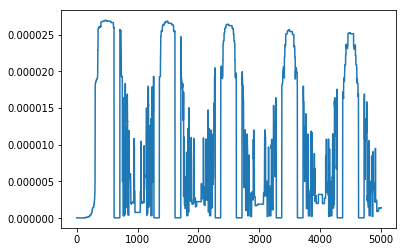

In [28]:
plt.plot(out[1].conductance)

In [ ]:
nonlineartrans(ASN300[0][0],onAmp,i,j,nod)

In [21]:
onAmp=2
nodesList=[[None]*10 for i in range(len(ASN300))]
stimulus=[[[] for i in range(len(ASN300))],[[] for i in range(len(ASN300))]]
acc=[[None]*10 for i in range(len(ASN300))]
init=[]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        init.append(inputPacker(nonlineartrans,ASN300,onAmp,i,j,nodesList,stimulus,acc))

In [22]:
acc=para_run(nonlineartrans,init,nCPU=10)

Running Linear Transformation Simulations
0
0
Parameter 1 , Network 1


Running Linear Transformation Simulations
0
1
Parameter 1 , Network 2


Running Linear Transformation Simulations
0
2
Parameter 1 , Network 3


Running Linear Transformation Simulations
0
3
Parameter 1 , Network 4


2020-09-03 16:50:37,005:INFO:First current path [115, 273, 193, 157, 296, 42, 125, 73, 248, 83] formed at time = 0.695 s.


Saving 10 Simulations for Network 1 Parameter 1
Regressing Parameter 1 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
0
4
Parameter 1 , Network 5


Running Regression: 200 nodes
Running Linear Transformation Simulations
0
5
Parameter 1 , Network 6

Running Regression: 250 nodes


2020-09-03 16:50:43,278:INFO:First current path [44, 108, 47, 2, 193, 127, 288, 139] formed at time = 0.589 s.


Saving 10 Simulations for Network 1 Parameter 2
Regressing Parameter 1 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 299 nodes
Running Linear Transformation Simulations
0
6
Parameter 1 , Network 7


2020-09-03 16:50:47,960:INFO:First current path [8, 169, 204, 68, 100, 72] formed at time = 0.446 s.


Saving 10 Simulations for Network 1 Parameter 3
Regressing Parameter 1 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
0
7
Parameter 1 , Network 8


Running Regression: 200 nodes
Running Regression: 300 nodes



2020-09-03 16:50:54,540:INFO:First current path [114, 62, 118, 282, 190, 145] formed at time = 0.449 s.


Saving 10 Simulations for Network 1 Parameter 4
Regressing Parameter 1 , Network 4
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
0
8
Parameter 1 , Network 9



Running Regression: 150 nodes


2020-09-03 16:50:56,886:INFO:First current path [19, 61, 51, 152, 186] formed at time = 0.391 s.


Saving 10 Simulations for Network 1 Parameter 5
Regressing Parameter 1 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
0
9
Parameter 1 , Network 10


Running Regression: 200 nodes

Running Regression: 250 nodes


2020-09-03 16:51:02,036:INFO:First current path [48, 284, 150, 56, 103] formed at time = 0.395 s.


Saving 10 Simulations for Network 1 Parameter 6
Regressing Parameter 1 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
1
0
Parameter 2 , Network 1


Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes



2020-09-03 16:51:07,271:INFO:First current path [1, 294, 57, 234] formed at time = 0.331 s.


Saving 10 Simulations for Network 1 Parameter 7
Regressing Parameter 1 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
1
1
Parameter 2 , Network 2
Running Regression: 300 nodes


Running Regression: 150 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
1
2
Parameter 2 , Network 3


Running Regression: 300 nodes


2020-09-03 16:51:12,708:INFO:First current path [2, 92, 250, 225] formed at time = 0.331 s.


Saving 10 Simulations for Network 1 Parameter 8
Regressing Parameter 1 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
1
3
Parameter 2 , Network 4




Running Regression: 300 nodes


2020-09-03 16:51:18,602:INFO:First current path [35, 194, 43, 242, 284, 74, 212, 286, 190, 24, 67] formed at time = 0.824 s.


Saving 10 Simulations for Network 2 Parameter 1
Regressing Parameter 2 , Network 1
Running Regression: 50 nodes


2020-09-03 16:51:18,848:INFO:First current path [2, 102, 244, 72] formed at time = 0.335 s.


Saving 10 Simulations for Network 1 Parameter 9
Regressing Parameter 1 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
1
4
Parameter 2 , Network 5


Running Regression: 200 nodes
Running Regression: 200 nodes



2020-09-03 16:51:24,831:INFO:First current path [4, 2, 145, 129] formed at time = 0.334 s.


Saving 10 Simulations for Network 1 Parameter 10

Regressing Parameter 1 , Network 10
Running Regression: 50 nodes
Running Regression: 300 nodes


2020-09-03 16:51:25,100:INFO:First current path [6, 18, 107, 136, 130, 204, 255, 108] formed at time = 0.565 s.


Saving 10 Simulations for Network 2 Parameter 2
Regressing Parameter 2 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
1
5
Parameter 2 , Network 6
Running Regression: 250 nodes
Running Regression: 250 nodes


Running Regression: 150 nodes
Running Regression: 150 nodes

Running Regression: 200 nodes
Running Regression: 200 nodes


2020-09-03 16:51:29,302:INFO:First current path [223, 108, 174, 114, 188, 66, 168, 287, 70] formed at time = 0.646 s.


Saving 10 Simulations for Network 2 Parameter 3
Regressing Parameter 2 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
1
6
Parameter 2 , Network 7


Running Regression: 300 nodes
Running Regression: 298 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 16:51:35,382:INFO:First current path [14, 39, 254, 53, 238, 124] formed at time = 0.449 s.


Saving 10 Simulations for Network 2 Parameter 4
Regressing Parameter 2 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
1
7
Parameter 2 , Network 8


Running Regression: 200 nodes

Running Regression: 300 nodes


2020-09-03 16:51:40,997:INFO:First current path [34, 257, 152, 55, 293, 194] formed at time = 0.454 s.


Saving 10 Simulations for Network 2 Parameter 5
Regressing Parameter 2 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
1
8
Parameter 2 , Network 9


Running Regression: 250 nodes
Running Regression: 150 nodes



2020-09-03 16:51:44,390:INFO:First current path [0, 238, 294, 32, 239] formed at time = 0.39 s.


Saving 10 Simulations for Network 2 Parameter 6
Regressing Parameter 2 , Network 6
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
1
9
Parameter 2 , Network 10
Running Regression: 150 nodes


Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 16:51:49,266:INFO:First current path [5, 174, 89, 237, 185] formed at time = 0.392 s.


Saving 10 Simulations for Network 2 Parameter 7
Regressing Parameter 2 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
2
0
Parameter 3 , Network 1


Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
2
1
Parameter 3 , Network 2


Running Regression: 250 nodes



2020-09-03 16:51:57,070:INFO:First current path [41, 78, 50, 75, 267] formed at time = 0.392 s.


Saving 10 Simulations for Network 2 Parameter 8
Regressing Parameter 2 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
2
2
Parameter 3 , Network 3


Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes

Running Linear Transformation Simulations
2
3
Parameter 3 , Network 4


2020-09-03 16:52:03,026:INFO:First current path [0, 31, 147, 257] formed at time = 0.335 s.


Saving 10 Simulations for Network 2 Parameter 9


Regressing Parameter 2 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:52:04,857:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 3 Parameter 1
Running Regression: 150 nodes
Regressing Parameter 3 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
2
4
Parameter 3 , Network 5



Running Regression: 150 nodes
Running Regression: 200 nodes


2020-09-03 16:52:07,085:INFO:First current path [0, 175, 119, 182] formed at time = 0.332 s.


Saving 10 Simulations for Network 2 Parameter 10
Regressing Parameter 2 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
2
5
Parameter 3 , Network 6


2020-09-03 16:52:11,952:INFO:First current path [14, 178, 0, 292, 210, 175, 183, 179, 154, 221] formed at time = 0.74 s.


Saving 10 Simulations for Network 3 Parameter 2
Regressing Parameter 3 , Network 2
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes

Running Regression: 150 nodes
Running Regression: 250 nodes


2020-09-03 16:52:14,118:INFO:First current path [145, 155, 107, 249, 171, 26, 126, 40, 207, 102] formed at time = 0.789 s.


Saving 10 Simulations for Network 3 Parameter 3
Regressing Parameter 3 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
2
6
Parameter 3 , Network 7


Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 292 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes



2020-09-03 16:52:20,050:INFO:First current path [1, 278, 235, 223, 143, 92, 26] formed at time = 0.526 s.


Saving 10 Simulations for Network 3 Parameter 4
Regressing Parameter 3 , Network 4
Running Regression: 50 nodes
Running Linear Transformation Simulations
2
7
Parameter 3 , Network 8


Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes



2020-09-03 16:52:24,489:INFO:First current path [2, 160, 32, 191, 205, 21] formed at time = 0.45 s.


Saving 10 Simulations for Network 3 Parameter 5
Regressing Parameter 3 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
2
8
Parameter 3 , Network 9


Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 16:52:30,715:INFO:First current path [74, 53, 121, 224, 28, 241] formed at time = 0.446 s.


Saving 10 Simulations for Network 3 Parameter 6
Regressing Parameter 3 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
2
9
Parameter 3 , Network 10


Running Regression: 150 nodes



2020-09-03 16:52:33,311:INFO:First current path [60, 244, 299, 122, 234, 250] formed at time = 0.466 s.


Saving 10 Simulations for Network 3 Parameter 7
Regressing Parameter 3 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
3
0
Parameter 4 , Network 1


Running Regression: 200 nodes
Running Regression: 250 nodes



2020-09-03 16:52:38,776:INFO:First current path [2, 83, 231, 111, 123] formed at time = 0.394 s.


Saving 10 Simulations for Network 3 Parameter 8
Regressing Parameter 3 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
3
1
Parameter 4 , Network 2


Running Regression: 300 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
3
2
Parameter 4 , Network 3


Running Regression: 300 nodes
Running Regression: 250 nodes



2020-09-03 16:52:46,712:INFO:First current path [55, 27, 65, 167, 102] formed at time = 0.393 s.


Saving 10 Simulations for Network 3 Parameter 9
Regressing Parameter 3 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
3
3
Parameter 4 , Network 4
Running Regression: 150 nodes



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:52:49,202:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 4 Parameter 1
Regressing Parameter 4 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes

Running Linear Transformation Simulations
3
4
Parameter 4 , Network 5


2020-09-03 16:52:52,671:INFO:First current path [1, 50, 73, 210] formed at time = 0.33 s.


Saving 10 Simulations for Network 3 Parameter 10
Running Regression: 200 nodes
Regressing Parameter 3 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Running Regression: 200 nodes
Running Linear Transformation Simulations
3
5
Parameter 4 , Network 6


Running Regression: 300 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:52:58,451:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 4 Parameter 2
Regressing Parameter 4 , Network 2
Running Regression: 50 nodes

Running Regression: 100 nodes


2020-09-03 16:52:59,378:INFO:First current path [95, 59, 87, 164, 194, 58, 50, 103, 151] formed at time = 0.657 s.


Saving 10 Simulations for Network 4 Parameter 3
Regressing Parameter 4 , Network 3
Running Regression: 50 nodes
Running Regression: 295 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
3
6
Parameter 4 , Network 7


Running Regression: 200 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
3
7
Parameter 4 , Network 8
Running Regression: 300 nodes


2020-09-03 16:53:04,996:INFO:First current path [100, 298, 62, 115, 73, 17, 207, 33, 7] formed at time = 0.655 s.


Saving 10 Simulations for Network 4 Parameter 4
Regressing Parameter 4 , Network 4
Running Regression: 50 nodes
Running Regression: 250 nodes


Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 299 nodes



2020-09-03 16:53:09,681:INFO:First current path [7, 21, 15, 103, 186, 149, 40] formed at time = 0.507 s.


Saving 10 Simulations for Network 4 Parameter 5
Regressing Parameter 4 , Network 5
Running Regression: 50 nodes
Running Linear Transformation Simulations
3
8
Parameter 4 , Network 9


Running Regression: 100 nodes
Running Regression: 297 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
3
9
Parameter 4 , Network 10


2020-09-03 16:53:15,829:INFO:First current path [94, 59, 34, 251, 179, 173, 155] formed at time = 0.514 s.


Saving 10 Simulations for Network 4 Parameter 6
Regressing Parameter 4 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 299 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
4
0
Parameter 5 , Network 1


Running Regression: 200 nodes



2020-09-03 16:53:20,221:INFO:First current path [65, 16, 140, 14, 55, 97] formed at time = 0.449 s.


Saving 10 Simulations for Network 4 Parameter 7
Regressing Parameter 4 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 299 nodes
Running Regression: 150 nodes



2020-09-03 16:53:22,656:INFO:First current path [1, 128, 26, 48, 76] formed at time = 0.393 s.


Saving 10 Simulations for Network 4 Parameter 8
Regressing Parameter 4 , Network 8
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
4
1
Parameter 5 , Network 2
Running Regression: 200 nodes


Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes

Running Regression: 300 nodes
Running Linear Transformation Simulations
4
2
Parameter 5 , Network 3


2020-09-03 16:53:28,032:INFO:First current path [10, 153, 224, 286, 281] formed at time = 0.393 s.


Saving 10 Simulations for Network 4 Parameter 9
Regressing Parameter 4 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:53:31,469:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 5 Parameter 1
Regressing Parameter 5 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
4
3
Parameter 5 , Network 4


2020-09-03 16:53:32,854:INFO:First current path [18, 175, 133, 162, 288] formed at time = 0.394 s.


Saving 10 Simulations for Network 4 Parameter 10
Regressing Parameter 4 , Network 10
Running Regression: 50 nodes
Running Regression: 150 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
4
4
Parameter 5 , Network 5


Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:53:38,157:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 5 Parameter 2
Regressing Parameter 5 , Network 2
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
4
5
Parameter 5 , Network 6


Running Regression: 200 nodes



2020-09-03 16:53:42,434:INFO:First current path [38, 206, 55, 130, 124, 32, 226, 139, 6, 48] formed at time = 0.684 s.


Saving 10 Simulations for Network 5 Parameter 3
Regressing Parameter 5 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 279 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
4
6
Parameter 5 , Network 7


Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 16:53:47,984:INFO:First current path [75, 224, 289, 129, 167, 263, 114, 43, 121, 235] formed at time = 0.7 s.


Saving 10 Simulations for Network 5 Parameter 4
Regressing Parameter 5 , Network 4
Running Regression: 50 nodes
Running Linear Transformation Simulations
4
7
Parameter 5 , Network 8


Running Regression: 100 nodes
Running Regression: 294 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes



2020-09-03 16:53:52,466:INFO:First current path [245, 298, 285, 171, 22, 269, 14, 142, 96] formed at time = 0.636 s.


Saving 10 Simulations for Network 5 Parameter 5
Regressing Parameter 5 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
4
8
Parameter 5 , Network 9


Running Regression: 299 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 16:53:58,166:INFO:First current path [67, 247, 9, 240, 8, 181, 60] formed at time = 0.508 s.


Saving 10 Simulations for Network 5 Parameter 6
Regressing Parameter 5 , Network 6
Running Regression: 50 nodes
Running Linear Transformation Simulations
4
9
Parameter 5 , Network 10


Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
5
0
Parameter 6 , Network 1


2020-09-03 16:54:02,419:INFO:First current path [4, 35, 283, 242, 175, 85] formed at time = 0.45 s.


Saving 10 Simulations for Network 5 Parameter 7
Regressing Parameter 5 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 16:54:06,973:INFO:First current path [10, 201, 99, 233, 75, 122] formed at time = 0.453 s.


Saving 10 Simulations for Network 5 Parameter 8
Regressing Parameter 5 , Network 8
Running Regression: 50 nodes
Running Linear Transformation Simulations
5
1
Parameter 6 , Network 2


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
5
2
Parameter 6 , Network 3


Running Regression: 200 nodes



2020-09-03 16:54:13,002:INFO:First current path [3, 77, 32, 65, 5] formed at time = 0.392 s.


Saving 10 Simulations for Network 5 Parameter 9
Regressing Parameter 5 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes

Running Regression: 300 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:54:13,870:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 6 Parameter 1
Regressing Parameter 6 , Network 1
Running Regression: 50 nodes
Running Linear Transformation Simulations
5
3
Parameter 6 , Network 4
Running Regression: 250 nodes


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 150 nodes



2020-09-03 16:54:16,927:INFO:First current path [0, 81, 52, 124, 118] formed at time = 0.391 s.


Saving 10 Simulations for Network 5 Parameter 10
Regressing Parameter 5 , Network 10
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
5
4
Parameter 6 , Network 5


Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:54:21,802:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 6 Parameter 2
Regressing Parameter 6 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
5
5
Parameter 6 , Network 6


Running Regression: 150 nodes
Running Regression: 281 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:54:24,685:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 6 Parameter 3
Regressing Parameter 6 , Network 3
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
5
6
Parameter 6 , Network 7


Running Regression: 200 nodes
Running Regression: 250 nodes

Running Regression: 300 nodes
Running Linear Transformation Simulations
5
7
Parameter 6 , Network 8


2020-09-03 16:54:30,337:INFO:First current path [13, 93, 203, 273, 144, 136, 142, 150, 174, 239, 216] formed at time = 0.794 s.


Saving 10 Simulations for Network 6 Parameter 4
Regressing Parameter 6 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 295 nodes

Running Regression: 200 nodes
Running Linear Transformation Simulations
5
8
Parameter 6 , Network 9


2020-09-03 16:54:34,474:INFO:First current path [260, 30, 56, 133, 234, 120, 194, 74, 169] formed at time = 0.618 s.


Saving 10 Simulations for Network 6 Parameter 5
Regressing Parameter 6 , Network 5
Running Regression: 50 nodes


Running Regression: 100 nodes
Running Regression: 298 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
5
9
Parameter 6 , Network 10
Running Regression: 200 nodes


2020-09-03 16:54:39,950:INFO:First current path [7, 137, 95, 260, 261, 282, 228, 190] formed at time = 0.559 s.


Saving 10 Simulations for Network 6 Parameter 6
Regressing Parameter 6 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 299 nodes
Running Linear Transformation Simulations
6
0
Parameter 7 , Network 1



Running Regression: 200 nodes


2020-09-03 16:54:43,837:INFO:First current path [63, 80, 220, 27, 22, 30, 14] formed at time = 0.514 s.


Saving 10 Simulations for Network 6 Parameter 7
Regressing Parameter 6 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
6
1
Parameter 7 , Network 2


Running Regression: 250 nodes

Running Regression: 200 nodes


2020-09-03 16:54:48,132:INFO:First current path [27, 108, 183, 267, 201, 175, 62, 118] formed at time = 0.614 s.


Saving 10 Simulations for Network 6 Parameter 8
Regressing Parameter 6 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
6
2
Parameter 7 , Network 3


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes



2020-09-03 16:54:53,333:INFO:First current path [1, 165, 82, 104, 202, 188] formed at time = 0.454 s.


Saving 10 Simulations for Network 6 Parameter 9
Regressing Parameter 6 , Network 9
Running Regression: 50 nodes
Running Linear Transformation Simulations
6
3
Parameter 7 , Network 4


Running Regression: 100 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:54:54,217:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 7 Parameter 1
Regressing Parameter 7 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes



2020-09-03 16:54:57,740:INFO:First current path [105, 271, 101, 92, 80, 168] formed at time = 0.455 s.


Saving 10 Simulations for Network 6 Parameter 10
Regressing Parameter 6 , Network 10
Running Regression: 50 nodes
Running Linear Transformation Simulations
6
4
Parameter 7 , Network 5


Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:55:00,534:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 7 Parameter 2
Regressing Parameter 7 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:55:03,001:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 7 Parameter 3
Regressing Parameter 7 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
6
5
Parameter 7 , Network 6


Running Regression: 200 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 278 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
6
6
Parameter 7 , Network 7
Running Regression: 250 nodes


2020-09-03 16:55:08,586:INFO:First current path [151, 103, 50, 53, 114, 37, 258, 259, 149, 96, 98] formed at time = 0.808 s.


Saving 10 Simulations for Network 7 Parameter 4
Regressing Parameter 7 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
6
7
Parameter 7 , Network 8


Running Regression: 293 nodes
Running Regression: 200 nodes



2020-09-03 16:55:13,422:INFO:First current path [7, 258, 168, 268, 260, 132, 102, 57, 64, 191] formed at time = 0.697 s.


Saving 10 Simulations for Network 7 Parameter 5
Regressing Parameter 7 , Network 5
Running Regression: 50 nodes
Running Regression: 294 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
6
8
Parameter 7 , Network 9


Running Regression: 200 nodes

Running Regression: 296 nodes


2020-09-03 16:55:20,124:INFO:First current path [5, 158, 10, 175, 34, 122, 157, 167] formed at time = 0.555 s.


Saving 10 Simulations for Network 7 Parameter 6
Regressing Parameter 7 , Network 6
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
6
9
Parameter 7 , Network 10
Running Regression: 100 nodes


Running Regression: 150 nodes

Running Regression: 200 nodes


2020-09-03 16:55:24,166:INFO:First current path [185, 152, 244, 124, 122, 179, 297, 173, 155] formed at time = 0.647 s.


Saving 10 Simulations for Network 7 Parameter 7
Regressing Parameter 7 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 298 nodes
Running Linear Transformation Simulations
7
0
Parameter 8 , Network 1


Running Regression: 150 nodes
Running Regression: 250 nodes

Running Regression: 200 nodes


2020-09-03 16:55:28,262:INFO:First current path [50, 148, 266, 85, 29, 16, 114] formed at time = 0.503 s.


Saving 10 Simulations for Network 7 Parameter 8
Regressing Parameter 7 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
7
1
Parameter 8 , Network 2


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 299 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
7
2
Parameter 8 , Network 3


2020-09-03 16:55:33,857:INFO:First current path [1, 9, 111, 216, 77, 271] formed at time = 0.449 s.


Saving 10 Simulations for Network 7 Parameter 9
Regressing Parameter 7 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
7
3
Parameter 8 , Network 4


Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:55:37,914:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 8 Parameter 1
Regressing Parameter 8 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes



2020-09-03 16:55:39,174:INFO:First current path [13, 12, 173, 224, 230, 265] formed at time = 0.448 s.


Saving 10 Simulations for Network 7 Parameter 10
Regressing Parameter 7 , Network 10
Running Regression: 50 nodes
Running Regression: 150 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
7
4
Parameter 8 , Network 5


Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:55:43,233:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 8 Parameter 2
Regressing Parameter 8 , Network 2
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
7
5
Parameter 8 , Network 6
Running Regression: 150 nodes
Running Regression: 300 nodes



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:55:46,406:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 8 Parameter 3
Regressing Parameter 8 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 286 nodes
Running Linear Transformation Simulations
7
6
Parameter 8 , Network 7


Running Regression: 200 nodes
Running Regression: 250 nodes



2020-09-03 16:55:51,612:INFO:First current path [13, 34, 61, 135, 82, 188, 183, 154, 153, 184] formed at time = 0.739 s.


Saving 10 Simulations for Network 8 Parameter 4
Regressing Parameter 8 , Network 4
Running Regression: 50 nodes
Running Regression: 300 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
7
7
Parameter 8 , Network 8


Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 291 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
7
8
Parameter 8 , Network 9


2020-09-03 16:55:56,022:INFO:First current path [1, 164, 12, 272, 185, 187, 58, 197, 190] formed at time = 0.616 s.


Saving 10 Simulations for Network 8 Parameter 5
Regressing Parameter 8 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 296 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
7
9
Parameter 8 , Network 10


2020-09-03 16:56:01,554:INFO:First current path [19, 29, 271, 0, 149, 17, 102, 63] formed at time = 0.56 s.


Saving 10 Simulations for Network 8 Parameter 6
Regressing Parameter 8 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
8
0
Parameter 9 , Network 1


Running Regression: 200 nodes



2020-09-03 16:56:06,037:INFO:First current path [64, 284, 150, 278, 201, 267, 183, 108, 27] formed at time = 0.695 s.


Saving 10 Simulations for Network 8 Parameter 7
Regressing Parameter 8 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
8
1
Parameter 9 , Network 2


Running Regression: 250 nodes



2020-09-03 16:56:09,518:INFO:First current path [3, 297, 217, 193, 144, 100, 188] formed at time = 0.514 s.


Saving 10 Simulations for Network 8 Parameter 8
Regressing Parameter 8 , Network 8
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:56:11,672:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 8 Parameter 10
Regressing Parameter 8 , Network 10
Running Regression: 50 nodes
Running Linear Transformation Simulations
8
2
Parameter 9 , Network 3


Running Regression: 100 nodes
Running Regression: 297 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes

Running Regression: 200 nodes


2020-09-03 16:56:14,053:INFO:First current path [111, 243, 258, 257, 42, 17, 66] formed at time = 0.53 s.


Saving 10 Simulations for Network 8 Parameter 9
Regressing Parameter 8 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
8
3
Parameter 9 , Network 4
Running Regression: 150 nodes



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:56:16,807:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 9 Parameter 1
Regressing Parameter 9 , Network 1
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
8
4
Parameter 9 , Network 5


Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:56:22,472:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 9 Parameter 2
Regressing Parameter 9 , Network 2
Running Regression: 50 nodes
Running Regression: 280 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
8
5
Parameter 9 , Network 6


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 299 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:56:25,471:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 9 Parameter 3
Regressing Parameter 9 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 285 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
8
6
Parameter 9 , Network 7



Running Regression: 250 nodes
Running Linear Transformation Simulations
8
7
Parameter 9 , Network 8


Running Regression: 293 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:56:33,999:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 9 Parameter 4
Regressing Parameter 9 , Network 4
Running Regression: 50 nodes

Running Regression: 100 nodes


2020-09-03 16:56:34,957:INFO:First current path [121, 209, 198, 258, 244, 247, 0, 213, 3, 219] formed at time = 0.692 s.


Saving 10 Simulations for Network 9 Parameter 5
Regressing Parameter 9 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 298 nodes
Running Linear Transformation Simulations
8
8
Parameter 9 , Network 9
Running Regression: 150 nodes


Running Regression: 200 nodes
Running Regression: 200 nodes



2020-09-03 16:56:39,452:INFO:First current path [119, 254, 61, 79, 128, 247, 258, 200, 100] formed at time = 0.672 s.


Saving 10 Simulations for Network 9 Parameter 6
Regressing Parameter 9 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
8
9
Parameter 9 , Network 10


Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
9
0
Parameter 10 , Network 1


2020-09-03 16:56:44,888:INFO:First current path [7, 288, 246, 74, 45, 138, 30, 237] formed at time = 0.572 s.


Saving 10 Simulations for Network 9 Parameter 7
Regressing Parameter 9 , Network 7
Running Regression: 50 nodes
Running Regression: 299 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes

Running Regression: 200 nodes


2020-09-03 16:56:48,767:INFO:First current path [6, 284, 113, 81, 146, 35, 211] formed at time = 0.501 s.


Saving 10 Simulations for Network 9 Parameter 8
Regressing Parameter 9 , Network 8
Running Regression: 50 nodes
Running Linear Transformation Simulations
9
1
Parameter 10 , Network 2


Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
9
2
Parameter 10 , Network 3


Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:56:53,271:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 9 Parameter 10
Regressing Parameter 9 , Network 10
Running Regression: 50 nodes

Running Regression: 100 nodes


2020-09-03 16:56:54,245:INFO:First current path [20, 244, 196, 67, 56, 80, 154] formed at time = 0.593 s.


Saving 10 Simulations for Network 9 Parameter 9
Regressing Parameter 9 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
9
3
Parameter 10 , Network 4
Running Regression: 150 nodes


Running Regression: 300 nodes

Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:56:56,658:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 10 Parameter 1
Regressing Parameter 10 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
9
4
Parameter 10 , Network 5


Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:02,826:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 10 Parameter 2
Regressing Parameter 10 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 285 nodes
Running Linear Transformation Simulations
9
5
Parameter 10 , Network 6
Running Regression: 250 nodes


Running Regression: 150 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:05,643:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 10 Parameter 3
Regressing Parameter 10 , Network 3
Running Regression: 50 nodes
Running Regression: 300 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
9
6
Parameter 10 , Network 7
Running Regression: 150 nodes


Running Regression: 279 nodes
Running Regression: 200 nodes

Running Regression: 250 nodes


2020-09-03 16:57:10,221:INFO:First current path [101, 293, 277, 236, 128, 7, 186, 35, 89, 72, 88, 190] formed at time = 0.885 s.


Saving 10 Simulations for Network 10 Parameter 4
Regressing Parameter 10 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
9
7
Parameter 10 , Network 8


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 285 nodes

Running Linear Transformation Simulations
9
8
Parameter 10 , Network 9


Running Regression: 295 nodes
Running Regression: 250 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:18,248:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 10 Parameter 5
Regressing Parameter 10 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes

Running Regression: 150 nodes
Running Linear Transformation Simulations
9
9
Parameter 10 , Network 10


Running Regression: 295 nodes
Running Regression: 200 nodes



2020-09-03 16:57:22,887:INFO:First current path [179, 150, 37, 274, 67, 22, 281, 286, 45, 295] formed at time = 0.684 s.


Saving 10 Simulations for Network 10 Parameter 7
Regressing Parameter 10 , Network 7
Running Regression: 50 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:23,105:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 10 Parameter 6
Regressing Parameter 10 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
10
0
Parameter 11 , Network 1


Running Regression: 200 nodes
Running Regression: 200 nodes



2020-09-03 16:57:27,469:INFO:First current path [51, 213, 93, 8, 280, 19, 224, 79, 164] formed at time = 0.661 s.


Saving 10 Simulations for Network 10 Parameter 8
Regressing Parameter 10 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
10
1
Parameter 11 , Network 2


Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:32,019:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 10 Parameter 10
Regressing Parameter 10 , Network 10
Running Regression: 50 nodes



2020-09-03 16:57:32,548:INFO:First current path [155, 183, 245, 150, 190, 25, 137, 24] formed at time = 0.568 s.


Saving 10 Simulations for Network 10 Parameter 9
Running Regression: 100 nodes
Regressing Parameter 10 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
10
2
Parameter 11 , Network 3
Running Regression: 299 nodes


Running Regression: 150 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
10
3
Parameter 11 , Network 4


Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes

Running Linear Transformation Simulations
10
4
Parameter 11 , Network 5


2020-09-03 16:57:42,391:INFO:First current path [131, 193, 253, 242, 138, 218, 187, 31, 289] formed at time = 0.68 s.


Saving 10 Simulations for Network 11 Parameter 1
Regressing Parameter 11 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 279 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes



2020-09-03 16:57:45,559:INFO:First current path [33, 96, 217, 171, 167, 86, 227, 251, 67, 269] formed at time = 0.681 s.


Saving 10 Simulations for Network 11 Parameter 2
Regressing Parameter 11 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
10
5
Parameter 11 , Network 6


Running Regression: 150 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:48,320:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 11 Parameter 3
Regressing Parameter 11 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
10
6
Parameter 11 , Network 7


Running Regression: 200 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:52,326:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 11 Parameter 4
Regressing Parameter 11 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
10
7
Parameter 11 , Network 8


Running Regression: 300 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:57:55,168:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 11 Parameter 5
Regressing Parameter 11 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 296 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
10
8
Parameter 11 , Network 9


Running Regression: 299 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:00,260:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 11 Parameter 6
Regressing Parameter 11 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:02,502:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 11 Parameter 7
Regressing Parameter 11 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 293 nodes
Running Linear Transformation Simulations
10
9
Parameter 11 , Network 10


Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:06,116:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 11 Parameter 8
Regressing Parameter 11 , Network 8
Running Regression: 50 nodes
Running Regression: 289 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
11
0
Parameter 12 , Network 1


Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:10,791:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 11 Parameter 9
Regressing Parameter 11 , Network 9
Running Regression: 50 nodes
Running Regression: 297 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
11
1
Parameter 12 , Network 2


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 282 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
11
2
Parameter 12 , Network 3


Running Regression: 279 nodes
Running Regression: 250 nodes



2020-09-03 16:58:19,240:INFO:First current path [174, 10, 92, 16, 200, 95, 223, 275, 30, 153, 224] formed at time = 0.786 s.


Saving 10 Simulations for Network 11 Parameter 10
Regressing Parameter 11 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
11
3
Parameter 12 , Network 4


Running Regression: 277 nodes

Running Regression: 200 nodes


2020-09-03 16:58:23,250:INFO:First current path [72, 259, 86, 52, 219, 186, 146, 183, 261] formed at time = 0.632 s.


Saving 10 Simulations for Network 12 Parameter 1
Regressing Parameter 12 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
11
4
Parameter 12 , Network 5


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 16:58:28,193:INFO:First current path [206, 244, 27, 238, 28, 181, 63, 31, 90, 149, 197] formed at time = 0.886 s.


Saving 10 Simulations for Network 12 Parameter 2
Regressing Parameter 12 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
11
5
Parameter 12 , Network 6


Running Regression: 150 nodes

Running Regression: 250 nodes


2020-09-03 16:58:30,574:INFO:First current path [36, 46, 262, 26, 87, 172, 41, 182, 134, 121, 245, 275] formed at time = 0.916 s.


Saving 10 Simulations for Network 12 Parameter 3
Regressing Parameter 12 , Network 3
Running Regression: 50 nodes
Running Regression: 300 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
11
6
Parameter 12 , Network 7


Running Regression: 200 nodes

Running Regression: 250 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:34,769:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 12 Parameter 4
Regressing Parameter 12 , Network 4
Running Regression: 50 nodes
Running Regression: 294 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
11
7
Parameter 12 , Network 8



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:38,355:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 12 Parameter 5
Regressing Parameter 12 , Network 5
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Running Regression: 299 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:41,848:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 12 Parameter 6
Regressing Parameter 12 , Network 6
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
11
8
Parameter 12 , Network 9


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:45,785:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 12 Parameter 7
Regressing Parameter 12 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
11
9
Parameter 12 , Network 10


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 295 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:58:49,568:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 12 Parameter 8
Regressing Parameter 12 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
12
0
Parameter 13 , Network 1


Running Regression: 150 nodes
Running Regression: 288 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
12
1
Parameter 13 , Network 2


Running Regression: 250 nodes
Running Regression: 283 nodes



2020-09-03 16:58:59,237:INFO:First current path [172, 80, 135, 12, 137, 44, 41, 40, 0] formed at time = 0.624 s.


Saving 10 Simulations for Network 12 Parameter 9
Regressing Parameter 12 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
12
2
Parameter 13 , Network 3


Running Regression: 280 nodes
Running Regression: 150 nodes



2020-09-03 16:59:01,266:INFO:First current path [41, 128, 171, 199, 215, 234, 206, 38, 9, 106] formed at time = 0.699 s.


Saving 10 Simulations for Network 12 Parameter 10
Regressing Parameter 12 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
12
3
Parameter 13 , Network 4


Running Regression: 200 nodes
Running Regression: 250 nodes



2020-09-03 16:59:06,825:INFO:First current path [13, 69, 35, 175, 76, 67, 43, 236, 24] formed at time = 0.622 s.


Saving 10 Simulations for Network 13 Parameter 1
Regressing Parameter 13 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
12
4
Parameter 13 , Network 5
Running Regression: 150 nodes


Running Regression: 299 nodes

Running Regression: 200 nodes


2020-09-03 16:59:10,789:INFO:First current path [125, 157, 210, 127, 46, 13, 156, 14, 70, 298, 184] formed at time = 0.767 s.


Saving 10 Simulations for Network 13 Parameter 2
Regressing Parameter 13 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
12
5
Parameter 13 , Network 6



Running Regression: 250 nodes
Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:15,824:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 13 Parameter 3
Regressing Parameter 13 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
12
6
Parameter 13 , Network 7
Running Regression: 150 nodes



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:18,310:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 13 Parameter 4
Regressing Parameter 13 , Network 4
Running Regression: 50 nodes
Running Regression: 300 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
12
7
Parameter 13 , Network 8


Running Regression: 300 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:21,738:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 13 Parameter 5
Regressing Parameter 13 , Network 5
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
12
8
Parameter 13 , Network 9
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:25,885:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 13 Parameter 6


Regressing Parameter 13 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 296 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Running Regression: 297 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:29,662:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 13 Parameter 7
Regressing Parameter 13 , Network 7
Running Regression: 50 nodes
Running Linear Transformation Simulations
12
9
Parameter 13 , Network 10


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:32,299:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 13 Parameter 8
Regressing Parameter 13 , Network 8
Running Regression: 50 nodes
Running Regression: 292 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
13
0
Parameter 14 , Network 1


Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 286 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
13
1
Parameter 14 , Network 2


Running Regression: 283 nodes



2020-09-03 16:59:41,745:INFO:First current path [31, 47, 209, 36, 295, 102, 163, 152, 74] formed at time = 0.633 s.


Saving 10 Simulations for Network 13 Parameter 9
Regressing Parameter 13 , Network 9
Running Regression: 50 nodes
Running Linear Transformation Simulations
13
2
Parameter 14 , Network 3
Running Regression: 100 nodes


Running Regression: 279 nodes
Running Regression: 150 nodes



2020-09-03 16:59:44,454:INFO:First current path [10, 125, 276, 216, 148, 272, 281, 273, 114] formed at time = 0.618 s.


Saving 10 Simulations for Network 13 Parameter 10
Regressing Parameter 13 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
13
3
Parameter 14 , Network 4


Running Regression: 200 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
13
4
Parameter 14 , Network 5


2020-09-03 16:59:51,100:INFO:First current path [93, 223, 160, 218, 105, 40, 250, 276, 135] formed at time = 0.635 s.


Saving 10 Simulations for Network 14 Parameter 1
Regressing Parameter 14 , Network 1
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes



2020-09-03 16:59:54,070:INFO:First current path [30, 154, 107, 182, 56, 10, 206, 44, 143, 271] formed at time = 0.677 s.


Saving 10 Simulations for Network 14 Parameter 2
Regressing Parameter 14 , Network 2
Running Regression: 50 nodes
Running Linear Transformation Simulations
13
5
Parameter 14 , Network 6


Running Regression: 100 nodes
Running Regression: 200 nodes

Running Regression: 150 nodes
Running Regression: 298 nodes
Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:58,499:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 14 Parameter 3
Regressing Parameter 14 , Network 3
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
13
6
Parameter 14 , Network 7
Running Regression: 100 nodes



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 16:59:59,935:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 14 Parameter 4
Regressing Parameter 14 , Network 4
Running Regression: 50 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
13
7
Parameter 14 , Network 8

Running Regression: 200 nodes


Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:02,366:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 14 Parameter 5
Regressing Parameter 14 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 296 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes

Running Linear Transformation Simulations
13
8
Parameter 14 , Network 9
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:07,235:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 14 Parameter 6
Regressing Parameter 14 , Network 6
Running Regression: 50 nodes


Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 298 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:11,319:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 14 Parameter 7
Regressing Parameter 14 , Network 7
Running Regression: 50 nodes
Running Regression: 292 nodes
Running Linear Transformation Simulations
13
9
Parameter 14 , Network 10


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 282 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:14,235:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 14 Parameter 8
Regressing Parameter 14 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
14
0
Parameter 15 , Network 1


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 287 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
14
1
Parameter 15 , Network 2


Running Regression: 283 nodes



2020-09-03 17:00:22,907:INFO:First current path [70, 269, 190, 184, 227, 284, 17, 16, 181] formed at time = 0.618 s.


Saving 10 Simulations for Network 14 Parameter 9
Regressing Parameter 14 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
14
2
Parameter 15 , Network 3
Running Regression: 150 nodes


Running Regression: 284 nodes

Running Regression: 200 nodes


2020-09-03 17:00:26,664:INFO:First current path [251, 185, 40, 115, 53, 65, 146, 77, 130, 197, 97] formed at time = 0.809 s.


Saving 10 Simulations for Network 14 Parameter 10
Regressing Parameter 14 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
14
3
Parameter 15 , Network 4


Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:00:31,800:INFO:First current path [290, 184, 183, 193, 195, 1, 257, 273, 283] formed at time = 0.633 s.


Saving 10 Simulations for Network 15 Parameter 1
Regressing Parameter 15 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
14
4
Parameter 15 , Network 5


Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:00:35,805:INFO:First current path [16, 177, 212, 159, 131, 35, 150, 87, 151] formed at time = 0.647 s.


Saving 10 Simulations for Network 15 Parameter 2
Regressing Parameter 15 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
14
5
Parameter 15 , Network 6


Running Regression: 150 nodes

Running Regression: 250 nodes
Running Regression: 300 nodes


2020-09-03 17:00:38,262:INFO:First current path [29, 68, 184, 132, 127, 282, 270, 283, 229, 107, 9] formed at time = 0.764 s.


Saving 10 Simulations for Network 15 Parameter 3
Regressing Parameter 15 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:41,828:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 15 Parameter 4
Regressing Parameter 15 , Network 4
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
14
6
Parameter 15 , Network 7


Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:46,038:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 15 Parameter 5
Regressing Parameter 15 , Network 5
Running Regression: 50 nodes
Running Linear Transformation Simulations
14
7
Parameter 15 , Network 8


Running Regression: 100 nodes
Running Regression: 298 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.
Running Regression: 298 nodes


2020-09-03 17:00:49,525:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 15 Parameter 6
Regressing Parameter 15 , Network 6
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
14
8
Parameter 15 , Network 9


Running Regression: 250 nodes
Running Regression: 294 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:54,986:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 15 Parameter 7
Regressing Parameter 15 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
14
9
Parameter 15 , Network 10
Running Regression: 250 nodes


Running Regression: 150 nodes
Running Regression: 292 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:00:58,115:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 15 Parameter 8
Regressing Parameter 15 , Network 8
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
15
0
Parameter 16 , Network 1
Running Regression: 150 nodes


Running Regression: 279 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:01:03,220:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 15 Parameter 9
Regressing Parameter 15 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
15
1
Parameter 16 , Network 2


Running Regression: 150 nodes
Running Regression: 289 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
15
2
Parameter 16 , Network 3


Running Regression: 281 nodes
Running Regression: 250 nodes



2020-09-03 17:01:11,375:INFO:First current path [0, 218, 295, 172, 84, 72, 151] formed at time = 0.517 s.


Saving 10 Simulations for Network 15 Parameter 10
Regressing Parameter 15 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
15
3
Parameter 16 , Network 4


Running Regression: 150 nodes
Running Regression: 279 nodes
Running Regression: 200 nodes



2020-09-03 17:01:16,027:INFO:First current path [28, 100, 36, 94, 297, 43, 92] formed at time = 0.503 s.


Saving 10 Simulations for Network 16 Parameter 1
Regressing Parameter 16 , Network 1
Running Regression: 50 nodes
Running Linear Transformation Simulations
15
4
Parameter 16 , Network 5


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes



2020-09-03 17:01:19,177:INFO:First current path [41, 210, 83, 110, 287, 290, 119, 194, 281] formed at time = 0.638 s.


Saving 10 Simulations for Network 16 Parameter 2
Regressing Parameter 16 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
15
5
Parameter 16 , Network 6


Running Regression: 150 nodes



2020-09-03 17:01:22,431:INFO:First current path [149, 65, 288, 246, 183, 22, 70, 140, 162, 242, 58] formed at time = 0.807 s.


Saving 10 Simulations for Network 16 Parameter 3
Regressing Parameter 16 , Network 3
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
15
6
Parameter 16 , Network 7



Running Regression: 250 nodes
Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:01:26,698:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 16 Parameter 4
Regressing Parameter 16 , Network 4
Running Regression: 50 nodes
Running Regression: 300 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
15
7
Parameter 16 , Network 8



Running Regression: 250 nodes


2020-09-03 17:01:29,205:INFO:First current path [7, 68, 29, 186, 100, 168, 43, 258, 164, 265, 156] formed at time = 0.77 s.


Saving 10 Simulations for Network 16 Parameter 5
Regressing Parameter 16 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:01:32,166:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 16 Parameter 6
Regressing Parameter 16 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 297 nodes
Running Linear Transformation Simulations
15
8
Parameter 16 , Network 9
Running Regression: 150 nodes


Running Regression: 200 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:01:36,789:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 16 Parameter 7
Regressing Parameter 16 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 294 nodes
Running Linear Transformation Simulations
15
9
Parameter 16 , Network 10
Running Regression: 150 nodes


Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 292 nodes
Running Regression: 279 nodes
Running Linear Transformation Simulations
16
0
Parameter 17 , Network 1
Running Regression: 250 nodes


2020-09-03 17:01:44,782:INFO:First current path [1, 243, 184, 154, 66, 8, 30] formed at time = 0.508 s.


Saving 10 Simulations for Network 16 Parameter 8
Regressing Parameter 16 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
16
1
Parameter 17 , Network 2
Running Regression: 279 nodes



Running Regression: 200 nodes


2020-09-03 17:01:48,963:INFO:First current path [85, 42, 147, 228, 189, 226, 291, 215, 288, 294] formed at time = 0.739 s.


Saving 10 Simulations for Network 16 Parameter 9
Regressing Parameter 16 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
16
2
Parameter 17 , Network 3


2020-09-03 17:01:52,247:INFO:First current path [55, 241, 48, 179, 257, 183, 158, 223, 216] formed at time = 0.636 s.


Saving 10 Simulations for Network 16 Parameter 10
Regressing Parameter 16 , Network 10
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
16
3
Parameter 17 , Network 4


Running Regression: 200 nodes
Running Regression: 300 nodes



2020-09-03 17:01:57,316:INFO:First current path [21, 143, 119, 208, 64, 196, 108] formed at time = 0.524 s.


Saving 10 Simulations for Network 17 Parameter 1
Regressing Parameter 17 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 297 nodes
Running Linear Transformation Simulations
16
4
Parameter 17 , Network 5


Running Regression: 200 nodes



2020-09-03 17:02:02,600:INFO:First current path [3, 292, 1, 115, 268, 111, 153] formed at time = 0.526 s.


Saving 10 Simulations for Network 17 Parameter 2
Regressing Parameter 17 , Network 2
Running Regression: 50 nodes
Running Regression: 296 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
16
5
Parameter 17 , Network 6


2020-09-03 17:02:06,080:INFO:First current path [134, 205, 75, 51, 202, 211, 63, 233, 84] formed at time = 0.64 s.


Saving 10 Simulations for Network 17 Parameter 3
Regressing Parameter 17 , Network 3
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes

Running Regression: 294 nodes


2020-09-03 17:02:08,134:INFO:First current path [111, 189, 88, 245, 46, 148, 132, 86, 134, 125, 277] formed at time = 0.811 s.


Saving 10 Simulations for Network 17 Parameter 4
Regressing Parameter 17 , Network 4
Running Regression: 50 nodes
Running Linear Transformation Simulations
16
6
Parameter 17 , Network 7
Running Regression: 100 nodes


Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes



2020-09-03 17:02:12,082:INFO:First current path [43, 139, 58, 130, 229, 120, 173, 2, 277, 82, 15] formed at time = 0.775 s.


Saving 10 Simulations for Network 17 Parameter 5
Regressing Parameter 17 , Network 5
Running Regression: 50 nodes
Running Linear Transformation Simulations
16
7
Parameter 17 , Network 8


Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 299 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
16
8
Parameter 17 , Network 9
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:02:17,044:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 17 Parameter 6
Regressing Parameter 17 , Network 6
Running Regression: 50 nodes


Running Regression: 297 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 281 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
16
9
Parameter 17 , Network 10


Running Regression: 279 nodes
Running Regression: 250 nodes



2020-09-03 17:02:23,713:INFO:First current path [73, 205, 199, 68, 222, 179, 51, 114, 128] formed at time = 0.652 s.


Saving 10 Simulations for Network 17 Parameter 7
Regressing Parameter 17 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
17
0
Parameter 18 , Network 1



Running Regression: 200 nodes


2020-09-03 17:02:27,357:INFO:First current path [37, 122, 187, 115, 14, 74, 283, 149] formed at time = 0.618 s.


Saving 10 Simulations for Network 17 Parameter 8
Regressing Parameter 17 , Network 8
Running Regression: 50 nodes
Running Regression: 281 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Running Linear Transformation Simulations
17
1
Parameter 18 , Network 2


2020-09-03 17:02:30,676:INFO:First current path [46, 62, 144, 95, 251, 128, 262, 196, 110] formed at time = 0.677 s.


Saving 10 Simulations for Network 17 Parameter 9
Regressing Parameter 17 , Network 9
Running Regression: 50 nodes


Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
17
2
Parameter 18 , Network 3


Running Regression: 300 nodes



2020-09-03 17:02:36,141:INFO:First current path [128, 234, 72, 70, 277, 249, 230, 24, 278] formed at time = 0.638 s.


Saving 10 Simulations for Network 17 Parameter 10
Regressing Parameter 17 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 297 nodes
Running Linear Transformation Simulations
17
3
Parameter 18 , Network 4


Running Regression: 200 nodes
Running Regression: 285 nodes



2020-09-03 17:02:42,741:INFO:First current path [31, 165, 95, 102, 268, 71, 8] formed at time = 0.523 s.


Saving 10 Simulations for Network 18 Parameter 1
Running Regression: 250 nodes
Regressing Parameter 18 , Network 1
Running Regression: 50 nodes
Running Linear Transformation Simulations
17
4
Parameter 18 , Network 5


Running Regression: 100 nodes
Running Regression: 150 nodes



2020-09-03 17:02:44,825:INFO:First current path [120, 169, 62, 177, 2, 128, 254, 232, 271] formed at time = 0.65 s.


Saving 10 Simulations for Network 18 Parameter 2
Regressing Parameter 18 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 289 nodes
Running Linear Transformation Simulations
17
5
Parameter 18 , Network 6


2020-09-03 17:02:47,847:INFO:First current path [58, 133, 266, 143, 222, 209, 85, 167] formed at time = 0.565 s.


Saving 10 Simulations for Network 18 Parameter 3
Regressing Parameter 18 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
17
6
Parameter 18 , Network 7


2020-09-03 17:02:52,107:INFO:First current path [7, 50, 26, 249, 39, 127, 197, 190] formed at time = 0.611 s.


Saving 10 Simulations for Network 18 Parameter 4
Regressing Parameter 18 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 293 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
17
7
Parameter 18 , Network 8



2020-09-03 17:02:55,625:INFO:First current path [122, 239, 238, 57, 69, 136, 221, 83, 244, 181, 185] formed at time = 0.781 s.


Saving 10 Simulations for Network 18 Parameter 5
Regressing Parameter 18 , Network 5
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 287 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 290 nodes
Running Regression: 200 nodes



2020-09-03 17:03:00,015:INFO:First current path [15, 125, 22, 243, 245, 263, 143, 273, 242, 62] formed at time = 0.718 s.


Saving 10 Simulations for Network 18 Parameter 6
Regressing Parameter 18 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
17
8
Parameter 18 , Network 9


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 287 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
17
9
Parameter 18 , Network 10


2020-09-03 17:03:05,988:INFO:First current path [89, 224, 197, 286, 260, 295, 199, 238] formed at time = 0.586 s.


Saving 10 Simulations for Network 18 Parameter 7
Regressing Parameter 18 , Network 7
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 288 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
18
0
Parameter 19 , Network 1



Running Regression: 200 nodes


2020-09-03 17:03:09,617:INFO:First current path [33, 52, 194, 2, 102, 140, 156, 151] formed at time = 0.562 s.


Saving 10 Simulations for Network 18 Parameter 8
Regressing Parameter 18 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 281 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:03:13,914:INFO:First current path [21, 154, 67, 7, 82, 194, 71, 77, 29] formed at time = 0.633 s.


Saving 10 Simulations for Network 18 Parameter 9
Regressing Parameter 18 , Network 9
Running Regression: 50 nodes
Running Linear Transformation Simulations
18
1
Parameter 19 , Network 2


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 296 nodes

Running Regression: 200 nodes


2020-09-03 17:03:17,463:INFO:First current path [68, 243, 244, 73, 218, 268, 162, 28, 52, 77] formed at time = 0.696 s.


Saving 10 Simulations for Network 18 Parameter 10
Regressing Parameter 18 , Network 10
Running Regression: 50 nodes
Running Linear Transformation Simulations
18
2
Parameter 19 , Network 3


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 291 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
18
3
Parameter 19 , Network 4


Running Regression: 250 nodes



2020-09-03 17:03:24,378:INFO:First current path [8, 149, 4, 193, 24, 53] formed at time = 0.463 s.


Saving 10 Simulations for Network 19 Parameter 1
Regressing Parameter 19 , Network 1
Running Regression: 50 nodes
Running Regression: 284 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
18
4
Parameter 19 , Network 5


Running Regression: 150 nodes



2020-09-03 17:03:27,641:INFO:First current path [3, 30, 46, 41, 210, 212, 23] formed at time = 0.517 s.


Saving 10 Simulations for Network 19 Parameter 2
Regressing Parameter 19 , Network 2
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 284 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes



2020-09-03 17:03:30,369:INFO:First current path [18, 68, 3, 81, 42, 80, 45, 2, 236] formed at time = 0.658 s.


Saving 10 Simulations for Network 19 Parameter 3
Regressing Parameter 19 , Network 3
Running Regression: 50 nodes
Running Linear Transformation Simulations
18
5
Parameter 19 , Network 6
Running Regression: 250 nodes


Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
18
6
Parameter 19 , Network 7


Running Regression: 200 nodes

Running Regression: 250 nodes


2020-09-03 17:03:34,484:INFO:First current path [15, 207, 67, 175, 203, 112, 144, 162, 189] formed at time = 0.635 s.


Saving 10 Simulations for Network 19 Parameter 4
Regressing Parameter 19 , Network 4
Running Regression: 50 nodes
Running Regression: 294 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes



2020-09-03 17:03:37,235:INFO:First current path [14, 120, 45, 135, 152, 66, 216, 13] formed at time = 0.554 s.


Saving 10 Simulations for Network 19 Parameter 5
Regressing Parameter 19 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
18
7
Parameter 19 , Network 8


Running Regression: 150 nodes
Running Regression: 290 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 283 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:03:42,077:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 19 Parameter 6
Regressing Parameter 19 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
18
8
Parameter 19 , Network 9


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 282 nodes
Running Regression: 200 nodes



2020-09-03 17:03:47,918:INFO:First current path [257, 181, 15, 13, 248, 75, 174, 14] formed at time = 0.618 s.


Saving 10 Simulations for Network 19 Parameter 7
Regressing Parameter 19 , Network 7
Running Regression: 50 nodes
Running Linear Transformation Simulations
18
9
Parameter 19 , Network 10


Running Regression: 278 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes



2020-09-03 17:03:51,495:INFO:First current path [33, 204, 227, 114, 95, 247, 45] formed at time = 0.529 s.


Saving 10 Simulations for Network 19 Parameter 8
Regressing Parameter 19 , Network 8
Running Regression: 50 nodes
Running Linear Transformation Simulations
19
0
Parameter 20 , Network 1
Running Regression: 200 nodes


Running Regression: 100 nodes
Running Regression: 278 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
19
1
Parameter 20 , Network 2



2020-09-03 17:03:56,792:INFO:First current path [9, 239, 196, 179, 11, 283, 35, 47] formed at time = 0.567 s.


Saving 10 Simulations for Network 19 Parameter 9
Regressing Parameter 19 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 289 nodes
Running Linear Transformation Simulations
19
2
Parameter 20 , Network 3
Running Regression: 200 nodes


2020-09-03 17:04:00,982:INFO:First current path [133, 240, 201, 0, 76, 87, 211, 158, 272] formed at time = 0.619 s.


Saving 10 Simulations for Network 19 Parameter 10
Regressing Parameter 19 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 290 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
19
3
Parameter 20 , Network 4


Running Regression: 200 nodes



2020-09-03 17:04:06,523:INFO:First current path [81, 199, 86, 272, 275, 102, 220] formed at time = 0.52 s.


Saving 10 Simulations for Network 20 Parameter 1
Regressing Parameter 20 , Network 1
Running Regression: 50 nodes
Running Regression: 286 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
19
4
Parameter 20 , Network 5


Running Regression: 150 nodes



2020-09-03 17:04:09,747:INFO:First current path [183, 224, 201, 63, 157, 40, 72, 136] formed at time = 0.641 s.


Saving 10 Simulations for Network 20 Parameter 2
Regressing Parameter 20 , Network 2
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 285 nodes
Running Linear Transformation Simulations
19
5
Parameter 20 , Network 6



2020-09-03 17:04:12,783:INFO:First current path [158, 132, 134, 177, 15, 48, 11, 179, 275] formed at time = 0.633 s.


Saving 10 Simulations for Network 20 Parameter 3
Running Regression: 250 nodes
Regressing Parameter 20 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
19
6
Parameter 20 , Network 7


2020-09-03 17:04:16,059:INFO:First current path [100, 156, 165, 235, 90, 149, 65, 78, 163] formed at time = 0.647 s.


Saving 10 Simulations for Network 20 Parameter 4
Regressing Parameter 20 , Network 4
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 288 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
19
7
Parameter 20 , Network 8


Running Regression: 278 nodes



2020-09-03 17:04:22,500:INFO:First current path [5, 240, 202, 110, 139, 115, 77] formed at time = 0.536 s.


Saving 10 Simulations for Network 20 Parameter 5
Regressing Parameter 20 , Network 5
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 283 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
19
8
Parameter 20 , Network 9


2020-09-03 17:04:25,215:INFO:First current path [22, 119, 47, 205, 256, 113, 66] formed at time = 0.51 s.


Saving 10 Simulations for Network 20 Parameter 6
Regressing Parameter 20 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 278 nodes



2020-09-03 17:04:28,066:INFO:First current path [0, 21, 105, 243, 36, 67, 253] formed at time = 0.522 s.


Saving 10 Simulations for Network 20 Parameter 7
Regressing Parameter 20 , Network 7
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
19
9
Parameter 20 , Network 10
Running Regression: 250 nodes


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:04:33,250:INFO:First current path [193, 70, 187, 68, 1, 19, 210, 241, 281] formed at time = 0.623 s.


Saving 10 Simulations for Network 20 Parameter 8
Regressing Parameter 20 , Network 8
Running Regression: 50 nodes
Running Regression: 289 nodes
Running Linear Transformation Simulations
20
0
Parameter 21 , Network 1
Running Regression: 100 nodes


Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 280 nodes
Running Regression: 200 nodes



2020-09-03 17:04:37,327:INFO:First current path [201, 88, 120, 275, 102, 115, 252, 183, 47, 172] formed at time = 0.753 s.


Saving 10 Simulations for Network 20 Parameter 9
Regressing Parameter 20 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
20
1
Parameter 21 , Network 2


Running Regression: 150 nodes
Running Regression: 282 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
20
2
Parameter 21 , Network 3



Running Regression: 250 nodes


2020-09-03 17:04:43,516:INFO:First current path [21, 130, 119, 186, 140, 52, 267] formed at time = 0.532 s.


Saving 10 Simulations for Network 20 Parameter 10
Regressing Parameter 20 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 286 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
20
3
Parameter 21 , Network 4



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:04:46,445:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 1
Regressing Parameter 21 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 279 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
20
4
Parameter 21 , Network 5


Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:04:51,004:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 2
Regressing Parameter 21 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:04:52,380:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 3
Regressing Parameter 21 , Network 3
Running Regression: 50 nodes
Running Regression: 150 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
20
5
Parameter 21 , Network 6


Running Regression: 150 nodes
Running Regression: 285 nodes
Running Regression: 200 nodes
Running Regression: 200 nodes

Running Regression: 285 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:04:57,071:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 4
Regressing Parameter 21 , Network 4
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
20
6
Parameter 21 , Network 7


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:01,225:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 5
Regressing Parameter 21 , Network 5
Running Regression: 50 nodes
Running Linear Transformation Simulations
20
7
Parameter 21 , Network 8
Running Regression: 100 nodes


Running Regression: 285 nodes
Running Regression: 150 nodes
Running Regression: 280 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:05,337:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 6
Regressing Parameter 21 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
20
8
Parameter 21 , Network 9


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 282 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:09,300:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 7
Regressing Parameter 21 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
20
9
Parameter 21 , Network 10


Running Regression: 250 nodes
Running Regression: 280 nodes

Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:12,764:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 8
Regressing Parameter 21 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
21
0
Parameter 22 , Network 1


Running Regression: 250 nodes
Running Regression: 283 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:18,177:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 9
Regressing Parameter 21 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
21
1
Parameter 22 , Network 2
Running Regression: 280 nodes


Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:22,395:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 21 Parameter 10
Regressing Parameter 21 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 278 nodes
Running Linear Transformation Simulations
21
2
Parameter 22 , Network 3


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
21
3
Parameter 22 , Network 4



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:28,572:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 1
Regressing Parameter 22 , Network 1
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 279 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
21
4
Parameter 22 , Network 5



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:32,356:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 2
Regressing Parameter 22 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 280 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
21
5
Parameter 22 , Network 6


Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:37,195:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 3
Regressing Parameter 22 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 293 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:40,495:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 4
Regressing Parameter 22 , Network 4
Running Regression: 50 nodes
Running Linear Transformation Simulations
21
6
Parameter 22 , Network 7
Running Regression: 100 nodes
Running Regression: 200 nodes


Running Regression: 150 nodes
Running Regression: 280 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:44,839:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 5
Running Linear Transformation Simulations
Regressing Parameter 22 , Network 5
21
Running Regression: 50 nodes
7
Parameter 22 , Network 8


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 297 nodes
Running Linear Transformation Simulations
21
8
Parameter 22 , Network 9


Running Regression: 200 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:49,615:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 6
Regressing Parameter 22 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 289 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
21
9
Parameter 22 , Network 10



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:53,718:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 7
Regressing Parameter 22 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 294 nodes

Running Regression: 200 nodes
Running Linear Transformation Simulations
22
0
Parameter 23 , Network 1


Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:05:58,820:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 8
Regressing Parameter 22 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 289 nodes
Running Regression: 250 nodes



2020-09-03 17:06:00,396:INFO:First current path [23, 225, 49, 271, 178, 73, 99, 181, 176, 150] formed at time = 0.693 s.


Saving 10 Simulations for Network 22 Parameter 9
Regressing Parameter 22 , Network 9
Running Regression: 50 nodes
Running Regression: 150 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
22
1
Parameter 23 , Network 2
Running Regression: 200 nodes


Running Regression: 200 nodes
Running Regression: 290 nodes
Running Regression: 250 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:05,675:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 22 Parameter 10
Regressing Parameter 22 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
22
2
Parameter 23 , Network 3


Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 286 nodes
Running Linear Transformation Simulations
22
3
Parameter 23 , Network 4


Running Regression: 279 nodes

Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:11,593:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 23 Parameter 1
Regressing Parameter 23 , Network 1
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
22
4
Parameter 23 , Network 5


Running Regression: 200 nodes

Running Regression: 288 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:16,444:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 23 Parameter 2
Regressing Parameter 23 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
22
5
Parameter 23 , Network 6



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:20,094:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 23 Parameter 3
Regressing Parameter 23 , Network 3
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 296 nodes
Running Linear Transformation Simulations
22
6
Parameter 23 , Network 7


Running Regression: 250 nodes

Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:24,935:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 23 Parameter 4
Regressing Parameter 23 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
22
7
Parameter 23 , Network 8
Running Regression: 291 nodes



Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:30,484:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 23 Parameter 5
Regressing Parameter 23 , Network 5
Running Regression: 50 nodes
Running Regression: 291 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
22
8
Parameter 23 , Network 9
Running Regression: 150 nodes



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:32,478:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 23 Parameter 6
Regressing Parameter 23 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 200 nodes

Running Regression: 296 nodes


2020-09-03 17:06:36,199:INFO:First current path [84, 178, 114, 126, 29, 135, 271, 203, 34, 52, 10, 241] formed at time = 0.863 s.


Saving 10 Simulations for Network 23 Parameter 7
Regressing Parameter 23 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
22
9
Parameter 23 , Network 10


Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:06:40,948:INFO:First current path [113, 224, 276, 221, 252, 25, 272, 26, 181, 192] formed at time = 0.696 s.


Saving 10 Simulations for Network 23 Parameter 8
Regressing Parameter 23 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 299 nodes
Running Linear Transformation Simulations
23
0
Parameter 24 , Network 1


Running Regression: 295 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:06:45,439:INFO:First current path [10, 117, 251, 246, 141, 73, 206, 92, 106] formed at time = 0.624 s.


Saving 10 Simulations for Network 23 Parameter 9
Regressing Parameter 23 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
23
1
Parameter 24 , Network 2


Running Regression: 292 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
23
2
Parameter 24 , Network 3



2020-09-03 17:06:50,844:INFO:First current path [22, 222, 23, 216, 26, 265, 201, 213, 204, 163] formed at time = 0.692 s.


Saving 10 Simulations for Network 23 Parameter 10
Regressing Parameter 23 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 291 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
23
3
Parameter 24 , Network 4


Running Regression: 200 nodes
Running Regression: 285 nodes

Running Linear Transformation Simulations
23
4
Parameter 24 , Network 5
Running Regression: 250 nodes


Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:06:59,425:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 24 Parameter 1
Regressing Parameter 24 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes

Running Regression: 285 nodes
Running Linear Transformation Simulations
23
5
Parameter 24 , Network 6


Running Regression: 200 nodes
Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:07:03,185:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 24 Parameter 2
Regressing Parameter 24 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes

Running Regression: 150 nodes


2020-09-03 17:07:05,152:INFO:First current path [56, 118, 273, 59, 247, 184, 74, 238, 60, 263, 219] formed at time = 0.791 s.


Saving 10 Simulations for Network 24 Parameter 3
Regressing Parameter 24 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
23
6
Parameter 24 , Network 7


Running Regression: 150 nodes
Running Regression: 200 nodes

Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
23
7
Parameter 24 , Network 8



Unfortunately, only 0 current paths found in simulation time.


2020-09-03 17:07:11,621:INFO:Unfortunately, no current path is formed in simulation time.


Saving 10 Simulations for Network 24 Parameter 4
Regressing Parameter 24 , Network 4
Running Regression: 50 nodes


2020-09-03 17:07:11,689:INFO:First current path [11, 54, 96, 110, 205, 77, 84, 254, 236, 140] formed at time = 0.681 s.


Saving 10 Simulations for Network 24 Parameter 5
Running Regression: 250 nodes
Regressing Parameter 24 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
23
8
Parameter 24 , Network 9


Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 200 nodes
Running Regression: 297 nodes



2020-09-03 17:07:16,827:INFO:First current path [56, 132, 12, 258, 28, 149, 150, 10, 75, 195, 113] formed at time = 0.824 s.


Saving 10 Simulations for Network 24 Parameter 6
Regressing Parameter 24 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
23
9
Parameter 24 , Network 10


Running Regression: 200 nodes



2020-09-03 17:07:20,502:INFO:First current path [10, 104, 200, 270, 38, 19, 66, 171, 264] formed at time = 0.638 s.


Saving 10 Simulations for Network 24 Parameter 7
Regressing Parameter 24 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 297 nodes
Running Regression: 296 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
24
0
Parameter 25 , Network 1


2020-09-03 17:07:24,911:INFO:First current path [22, 69, 250, 34, 178, 30, 209, 180, 53] formed at time = 0.697 s.


Saving 10 Simulations for Network 24 Parameter 8
Regressing Parameter 24 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 296 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:07:28,902:INFO:First current path [53, 60, 123, 91, 38, 16, 219, 120, 277] formed at time = 0.639 s.


Saving 10 Simulations for Network 24 Parameter 9
Regressing Parameter 24 , Network 9
Running Regression: 50 nodes
Running Linear Transformation Simulations
24
1
Parameter 25 , Network 2


Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 298 nodes
Running Linear Transformation Simulations
24
2
Parameter 25 , Network 3
Running Regression: 200 nodes


2020-09-03 17:07:34,645:INFO:First current path [28, 228, 37, 80, 263, 16, 155, 25] formed at time = 0.585 s.


Saving 10 Simulations for Network 24 Parameter 10
Regressing Parameter 24 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 295 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
24
3
Parameter 25 , Network 4


Running Regression: 200 nodes
Running Regression: 293 nodes



2020-09-03 17:07:40,499:INFO:First current path [212, 148, 266, 186, 85, 192, 169, 129, 150, 109] formed at time = 0.689 s.


Saving 10 Simulations for Network 25 Parameter 1
Regressing Parameter 25 , Network 1
Running Regression: 50 nodes
Running Linear Transformation Simulations
24
4
Parameter 25 , Network 5


Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
24
5
Parameter 25 , Network 6


2020-09-03 17:07:45,083:INFO:First current path [82, 229, 5, 254, 73, 294, 75, 148, 253] formed at time = 0.612 s.


Saving 10 Simulations for Network 25 Parameter 2
Regressing Parameter 25 , Network 2
Running Regression: 50 nodes


Running Regression: 297 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes



2020-09-03 17:07:48,586:INFO:First current path [192, 292, 222, 176, 153, 195, 17, 168, 136, 99] formed at time = 0.696 s.


Saving 10 Simulations for Network 25 Parameter 3
Regressing Parameter 25 , Network 3
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
24
6
Parameter 25 , Network 7


Running Regression: 150 nodes
Running Regression: 299 nodes

Running Regression: 250 nodes


2020-09-03 17:07:52,074:INFO:First current path [211, 259, 133, 156, 268, 172, 148, 89, 226, 8] formed at time = 0.728 s.


Saving 10 Simulations for Network 25 Parameter 4
Regressing Parameter 25 , Network 4
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
24
7
Parameter 25 , Network 8


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:07:56,537:INFO:First current path [83, 243, 218, 296, 191, 49, 176, 170, 72, 255, 177] formed at time = 0.794 s.


Saving 10 Simulations for Network 25 Parameter 5
Regressing Parameter 25 , Network 5
Running Regression: 50 nodes
Running Regression: 299 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
24
8
Parameter 25 , Network 9
Running Regression: 150 nodes


Running Regression: 250 nodes
Running Regression: 299 nodes

Running Regression: 200 nodes


2020-09-03 17:08:00,406:INFO:First current path [187, 247, 201, 299, 248, 50, 244, 78, 174, 245] formed at time = 0.699 s.


Saving 10 Simulations for Network 25 Parameter 6
Regressing Parameter 25 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
24
9
Parameter 25 , Network 10


Running Regression: 250 nodes
Running Regression: 299 nodes
Running Regression: 200 nodes



2020-09-03 17:08:04,960:INFO:First current path [3, 91, 296, 217, 81, 27, 48, 96] formed at time = 0.581 s.


Saving 10 Simulations for Network 25 Parameter 7
Regressing Parameter 25 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
25
0
Parameter 26 , Network 1



Running Regression: 300 nodes


2020-09-03 17:08:08,101:INFO:First current path [7, 244, 34, 117, 1, 19, 17, 289] formed at time = 0.586 s.


Saving 10 Simulations for Network 25 Parameter 8
Regressing Parameter 25 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
25
1
Parameter 26 , Network 2


Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:08:13,393:INFO:First current path [87, 277, 35, 148, 201, 225, 2, 118, 43] formed at time = 0.677 s.


Saving 10 Simulations for Network 25 Parameter 9
Regressing Parameter 25 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
25
2
Parameter 26 , Network 3


Running Regression: 299 nodes
Running Regression: 200 nodes



2020-09-03 17:08:17,895:INFO:First current path [3, 70, 272, 270, 12, 264, 237, 295] formed at time = 0.565 s.


Saving 10 Simulations for Network 25 Parameter 10
Regressing Parameter 25 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
25
3
Parameter 26 , Network 4


Running Regression: 296 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes

Running Linear Transformation Simulations
25
4
Parameter 26 , Network 5


2020-09-03 17:08:23,651:INFO:First current path [175, 151, 137, 44, 111, 292, 219, 185, 291] formed at time = 0.661 s.


Saving 10 Simulations for Network 26 Parameter 1
Regressing Parameter 26 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 298 nodes
Running Regression: 150 nodes



2020-09-03 17:08:26,835:INFO:First current path [88, 158, 218, 287, 16, 121, 290, 184, 10] formed at time = 0.625 s.


Saving 10 Simulations for Network 26 Parameter 2
Regressing Parameter 26 , Network 2
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
25
5
Parameter 26 , Network 6


Running Regression: 150 nodes
Running Regression: 299 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:08:31,328:INFO:First current path [239, 174, 47, 281, 17, 61, 192, 262, 132, 96] formed at time = 0.708 s.


Saving 10 Simulations for Network 26 Parameter 3
Regressing Parameter 26 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
25
6
Parameter 26 , Network 7


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes

Running Regression: 200 nodes


2020-09-03 17:08:35,221:INFO:First current path [128, 60, 95, 106, 164, 174, 169, 90, 76] formed at time = 0.628 s.


Saving 10 Simulations for Network 26 Parameter 4
Regressing Parameter 26 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
25
7
Parameter 26 , Network 8


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 298 nodes
Running Regression: 200 nodes



2020-09-03 17:08:39,567:INFO:First current path [298, 252, 102, 110, 299, 168, 65, 209] formed at time = 0.559 s.


Saving 10 Simulations for Network 26 Parameter 5
Regressing Parameter 26 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
25
8
Parameter 26 , Network 9


Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes



2020-09-03 17:08:43,900:INFO:First current path [10, 71, 107, 86, 281, 130, 117, 103] formed at time = 0.567 s.


Saving 10 Simulations for Network 26 Parameter 6
Regressing Parameter 26 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
25
9
Parameter 26 , Network 10


Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:08:48,313:INFO:First current path [7, 237, 146, 178, 160, 53, 32, 102] formed at time = 0.577 s.


Saving 10 Simulations for Network 26 Parameter 7
Regressing Parameter 26 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
26
0
Parameter 27 , Network 1
Running Regression: 250 nodes


Running Regression: 300 nodes

Running Regression: 200 nodes


2020-09-03 17:08:52,197:INFO:First current path [119, 44, 289, 176, 241, 181, 51, 129, 50] formed at time = 0.637 s.


Saving 10 Simulations for Network 26 Parameter 8
Regressing Parameter 26 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
26
1
Parameter 27 , Network 2
Running Regression: 250 nodes


Running Regression: 300 nodes
Running Regression: 200 nodes



2020-09-03 17:08:57,493:INFO:First current path [29, 255, 47, 182, 249, 65, 177] formed at time = 0.525 s.


Saving 10 Simulations for Network 26 Parameter 9
Regressing Parameter 26 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
26
2
Parameter 27 , Network 3


Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 299 nodes



2020-09-03 17:09:00,804:INFO:First current path [0, 126, 25, 81, 8, 203, 145] formed at time = 0.51 s.


Saving 10 Simulations for Network 26 Parameter 10
Regressing Parameter 26 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
26
3
Parameter 27 , Network 4
Running Regression: 150 nodes


Running Regression: 299 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
26
4
Parameter 27 , Network 5


Running Regression: 250 nodes



2020-09-03 17:09:08,258:INFO:First current path [3, 111, 150, 206, 239, 296, 79] formed at time = 0.507 s.


Saving 10 Simulations for Network 27 Parameter 1
Regressing Parameter 27 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 299 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
26
5
Parameter 27 , Network 6



Running Regression: 300 nodes
Running Regression: 200 nodes


2020-09-03 17:09:12,504:INFO:First current path [92, 9, 186, 89, 121, 158, 67, 61, 225] formed at time = 0.698 s.


Saving 10 Simulations for Network 27 Parameter 2
Regressing Parameter 27 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes



2020-09-03 17:09:14,978:INFO:First current path [292, 282, 140, 112, 53, 160, 184, 281] formed at time = 0.572 s.


Saving 10 Simulations for Network 27 Parameter 3
Regressing Parameter 27 , Network 3
Running Regression: 50 nodes
Running Linear Transformation Simulations
26
6
Parameter 27 , Network 7
Running Regression: 250 nodes


Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes

Running Regression: 200 nodes
Running Linear Transformation Simulations
26
7
Parameter 27 , Network 8


2020-09-03 17:09:19,129:INFO:First current path [19, 160, 16, 128, 200, 73, 195] formed at time = 0.502 s.


Saving 10 Simulations for Network 27 Parameter 4
Regressing Parameter 27 , Network 4
Running Regression: 50 nodes


Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
26
8
Parameter 27 , Network 9



2020-09-03 17:09:23,735:INFO:First current path [5, 146, 170, 12, 16, 226, 27] formed at time = 0.504 s.


Saving 10 Simulations for Network 27 Parameter 5
Regressing Parameter 27 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 299 nodes
Running Linear Transformation Simulations
26
9
Parameter 27 , Network 10
Running Regression: 200 nodes



2020-09-03 17:09:28,241:INFO:First current path [60, 22, 272, 182, 201, 244, 105, 161] formed at time = 0.589 s.


Saving 10 Simulations for Network 27 Parameter 6
Regressing Parameter 27 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes

Running Regression: 250 nodes


2020-09-03 17:09:31,256:INFO:First current path [230, 288, 174, 103, 153, 1, 82, 30] formed at time = 0.575 s.


Saving 10 Simulations for Network 27 Parameter 7
Regressing Parameter 27 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
27
0
Parameter 28 , Network 1


Running Regression: 150 nodes
Running Regression: 200 nodes

Running Regression: 250 nodes


2020-09-03 17:09:35,454:INFO:First current path [74, 234, 50, 196, 150, 256, 11] formed at time = 0.526 s.


Saving 10 Simulations for Network 27 Parameter 8
Regressing Parameter 27 , Network 8
Running Regression: 50 nodes
Running Regression: 299 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
27
1
Parameter 28 , Network 2


Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes



2020-09-03 17:09:40,222:INFO:First current path [2, 225, 254, 209, 298, 204, 135] formed at time = 0.517 s.


Saving 10 Simulations for Network 27 Parameter 9
Regressing Parameter 27 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
27
2
Parameter 28 , Network 3


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 298 nodes

Running Regression: 200 nodes


2020-09-03 17:09:44,386:INFO:First current path [7, 78, 230, 136, 74, 181] formed at time = 0.445 s.


Saving 10 Simulations for Network 27 Parameter 10
Regressing Parameter 27 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
27
3
Parameter 28 , Network 4


Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
27
4
Parameter 28 , Network 5


2020-09-03 17:09:50,227:INFO:First current path [31, 135, 226, 254, 264, 227, 208] formed at time = 0.501 s.


Saving 10 Simulations for Network 28 Parameter 1
Regressing Parameter 28 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
27
5
Parameter 28 , Network 6
Running Regression: 200 nodes


2020-09-03 17:09:55,699:INFO:First current path [65, 261, 283, 218, 284, 37, 49] formed at time = 0.519 s.


Saving 10 Simulations for Network 28 Parameter 2
Running Regression: 300 nodes
Regressing Parameter 28 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
27
6
Parameter 28 , Network 7



Running Regression: 150 nodes


2020-09-03 17:09:58,076:INFO:First current path [12, 255, 221, 260, 212, 47, 41] formed at time = 0.52 s.


Saving 10 Simulations for Network 28 Parameter 3
Regressing Parameter 28 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
27
7
Parameter 28 , Network 8


Running Regression: 200 nodes



2020-09-03 17:10:02,284:INFO:First current path [7, 159, 201, 241, 43, 197, 57] formed at time = 0.5 s.


Saving 10 Simulations for Network 28 Parameter 4
Regressing Parameter 28 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Running Regression: 200 nodes


2020-09-03 17:10:06,695:INFO:First current path [164, 32, 46, 149, 11, 186, 205] formed at time = 0.505 s.


Saving 10 Simulations for Network 28 Parameter 5
Running Linear Transformation Simulations
27
8
Parameter 28 , Network 9


Regressing Parameter 28 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes

Running Regression: 200 nodes


2020-09-03 17:10:11,013:INFO:First current path [10, 285, 270, 294, 264, 251, 30] formed at time = 0.551 s.


Saving 10 Simulations for Network 28 Parameter 6
Running Linear Transformation Simulations
27
9
Parameter 28 , Network 10


Regressing Parameter 28 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes

Running Regression: 250 nodes


2020-09-03 17:10:14,724:INFO:First current path [246, 251, 217, 200, 277, 155, 183] formed at time = 0.516 s.


Saving 10 Simulations for Network 28 Parameter 7
Regressing Parameter 28 , Network 7
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
28
0
Parameter 29 , Network 1


Running Regression: 150 nodes



2020-09-03 17:10:18,267:INFO:First current path [2, 105, 90, 227, 288, 230] formed at time = 0.449 s.


Saving 10 Simulations for Network 28 Parameter 8
Regressing Parameter 28 , Network 8
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 299 nodes
Running Linear Transformation Simulations
28
1
Parameter 29 , Network 2
Running Regression: 150 nodes


Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
28
2
Parameter 29 , Network 3


2020-09-03 17:10:24,876:INFO:First current path [228, 185, 160, 131, 147, 63, 5] formed at time = 0.526 s.


Saving 10 Simulations for Network 28 Parameter 9
Regressing Parameter 28 , Network 9
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes

Running Linear Transformation Simulations
28
3
Parameter 29 , Network 4


2020-09-03 17:10:28,251:INFO:First current path [1, 79, 170, 211, 163, 147] formed at time = 0.456 s.


Saving 10 Simulations for Network 28 Parameter 10
Regressing Parameter 28 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
28
4
Parameter 29 , Network 5



Running Regression: 250 nodes


2020-09-03 17:10:35,129:INFO:First current path [85, 220, 175, 186, 165, 139, 274] formed at time = 0.526 s.


Saving 10 Simulations for Network 29 Parameter 1
Regressing Parameter 29 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
28
5
Parameter 29 , Network 6


2020-09-03 17:10:38,216:INFO:First current path [1, 61, 204, 36, 223, 152] formed at time = 0.446 s.


Saving 10 Simulations for Network 29 Parameter 2
Regressing Parameter 29 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
28
6
Parameter 29 , Network 7



2020-09-03 17:10:41,322:INFO:First current path [120, 78, 204, 183, 130, 79, 288] formed at time = 0.511 s.


Saving 10 Simulations for Network 29 Parameter 3
Regressing Parameter 29 , Network 3
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
28
7
Parameter 29 , Network 8


Running Regression: 200 nodes



2020-09-03 17:10:45,838:INFO:First current path [7, 222, 13, 90, 64, 288] formed at time = 0.445 s.


Saving 10 Simulations for Network 29 Parameter 4
Regressing Parameter 29 , Network 4
Running Regression: 50 nodes
Running Regression: 250 nodes
Running Regression: 100 nodes
Running Regression: 300 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
28
8
Parameter 29 , Network 9
Running Regression: 200 nodes


2020-09-03 17:10:50,447:INFO:First current path [2, 92, 33, 240, 120, 12] formed at time = 0.448 s.


Saving 10 Simulations for Network 29 Parameter 5
Regressing Parameter 29 , Network 5
Running Regression: 50 nodes
Running Regression: 300 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
28
9
Parameter 29 , Network 10


Running Regression: 200 nodes



2020-09-03 17:10:55,167:INFO:First current path [3, 196, 214, 84, 202, 2] formed at time = 0.445 s.


Saving 10 Simulations for Network 29 Parameter 6
Regressing Parameter 29 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes

Running Linear Transformation Simulations
29
0
Parameter 30 , Network 1


2020-09-03 17:10:58,445:INFO:First current path [43, 159, 176, 247, 101, 164] formed at time = 0.47 s.


Saving 10 Simulations for Network 29 Parameter 7
Regressing Parameter 29 , Network 7
Running Regression: 50 nodes


Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes
Running Regression: 300 nodes



2020-09-03 17:11:02,749:INFO:First current path [182, 166, 252, 81, 291, 205] formed at time = 0.45 s.


Saving 10 Simulations for Network 29 Parameter 8
Regressing Parameter 29 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
29
1
Parameter 30 , Network 2


Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Linear Transformation Simulations
29
2
Parameter 30 , Network 3


2020-09-03 17:11:07,585:INFO:First current path [1, 190, 72, 135, 23, 138] formed at time = 0.451 s.


Saving 10 Simulations for Network 29 Parameter 9
Regressing Parameter 29 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Linear Transformation Simulations
29
3
Parameter 30 , Network 4



Running Regression: 200 nodes


2020-09-03 17:11:11,956:INFO:First current path [4, 106, 50, 103, 29, 232] formed at time = 0.451 s.


Saving 10 Simulations for Network 29 Parameter 10
Regressing Parameter 29 , Network 10
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
29
4
Parameter 30 , Network 5


Running Regression: 200 nodes



2020-09-03 17:11:17,836:INFO:First current path [24, 292, 111, 132, 228, 41] formed at time = 0.455 s.


Saving 10 Simulations for Network 30 Parameter 1
Regressing Parameter 30 , Network 1
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 250 nodes
Running Linear Transformation Simulations
29
5
Parameter 30 , Network 6
Running Regression: 300 nodes


Running Regression: 150 nodes

Running Regression: 200 nodes


2020-09-03 17:11:21,986:INFO:First current path [11, 262, 253, 154, 109, 87] formed at time = 0.446 s.


Saving 10 Simulations for Network 30 Parameter 2
Regressing Parameter 30 , Network 2
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 299 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
29
6
Parameter 30 , Network 7


Running Regression: 250 nodes



2020-09-03 17:11:25,565:INFO:First current path [7, 51, 81, 223, 263, 142] formed at time = 0.458 s.


Saving 10 Simulations for Network 30 Parameter 3
Regressing Parameter 30 , Network 3
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
29
7
Parameter 30 , Network 8


Running Regression: 300 nodes

Running Regression: 200 nodes
Running Regression: 250 nodes


2020-09-03 17:11:29,642:INFO:First current path [7, 99, 280, 294, 68, 69] formed at time = 0.446 s.


Saving 10 Simulations for Network 30 Parameter 4
Regressing Parameter 30 , Network 4
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Linear Transformation Simulations
29
8
Parameter 30 , Network 9


Running Regression: 250 nodes
Running Regression: 200 nodes

Running Regression: 300 nodes


2020-09-03 17:11:34,508:INFO:First current path [28, 185, 128, 172, 0, 108] formed at time = 0.448 s.


Saving 10 Simulations for Network 30 Parameter 5
Regressing Parameter 30 , Network 5
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Linear Transformation Simulations
29
9
Parameter 30 , Network 10


Running Regression: 150 nodes
Running Regression: 250 nodes

Running Regression: 300 nodes


2020-09-03 17:11:37,563:INFO:First current path [16, 17, 199, 11, 257, 177] formed at time = 0.45 s.


Saving 10 Simulations for Network 30 Parameter 6
Regressing Parameter 30 , Network 6
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 200 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes



2020-09-03 17:11:42,251:INFO:First current path [77, 240, 138, 127, 145, 82] formed at time = 0.455 s.


Saving 10 Simulations for Network 30 Parameter 7
Regressing Parameter 30 , Network 7
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes

Running Regression: 300 nodes
Running Regression: 200 nodes


2020-09-03 17:11:45,961:INFO:First current path [195, 254, 54, 20, 283, 154] formed at time = 0.446 s.


Saving 10 Simulations for Network 30 Parameter 8
Regressing Parameter 30 , Network 8
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 300 nodes
Running Regression: 250 nodes
Running Regression: 200 nodes



2020-09-03 17:11:50,359:INFO:First current path [1, 27, 162, 286, 147] formed at time = 0.39 s.


Saving 10 Simulations for Network 30 Parameter 9
Regressing Parameter 30 , Network 9
Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes



2020-09-03 17:11:53,924:INFO:First current path [0, 175, 295, 177, 169] formed at time = 0.393 s.


Saving 10 Simulations for Network 30 Parameter 10
Regressing Parameter 30 , Network 10
Running Regression: 50 nodes
Running Regression: 200 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 300 nodes
Running Regression: 300 nodes



In [25]:
count=0
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])):
        ASN300[i][j]['Accuracy']['Linear Transformation']=acc[count]
        count=count+1

In [26]:
pwd

'/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks'

In [24]:
name='networks_NoninearTransformation_2V.pkl'
with open(name, 'wb') as f:
    pickle.dump([ASN300], f)

In [30]:
#Calculate nodesList
nodesList=[[None]*10 for i in range(len(ASN300))]
for i in range(len(ASN300)):
    for j in range(len(ASN300[i])): #for each network:
        if len(ASN300[i][j]['G']) >= 250:
            nodesList[i][j]=[50,100,150,200,250,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)
        elif len(ASN300[i][j]['G']) >= 200 and len(ASN300[i][j]['G']) < 250:
            nodesList[i][j]=[50,100,150,200,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  
        elif len(ASN300[i][j]['G']) >= 150 and len(ASN300[i][j]['G']) < 200:
            nodesList[i][j]=[50,100,150,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)  z
        elif len(ASN300[i][j]['G']) >= 100 and len(ASN300[i][j]['G']) < 150:
            nodesList[i][j]=[50,100,len(ASN300[i][j]['G'])]#range(50, len(ws300[i][0])+1,50)

#### DO NOT DELETE COMMENTS BELOW

In [31]:
# #Current and Communicability Matrices:
# if ( os.path.isfile(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_29')):
#     print('Running Communicability Analysis')
#     time_index=[[None]*10 for i in range(len(ASN300))]
#     junctions=[[None]*10 for i in range(len(ASN300))]
#     sources=[[None]*10 for i in range(len(ASN300))]
#     drains=[[None]*10 for i in range(len(ASN300))]
#     count1=0
#     count2=0
#     count3=0
#     for i in tqdm(range(len(ASN300))):
#         check_memory()
#         #load corresponding results_ASN file
#         print('Loading Parameter ' + str(i+1) +' - All Networks')
#         [results_ASN]=decompress_pickle(r'/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/simulations_LinearTransformation_'+str(i))
#         print('Loaded Parameter ' + str(i+1) +' - All Networks')
#         check_memory()
#         for j in range(len(results_ASN)):
#             print('Calculating COMM Matrix for Parameter ' + str(i+1) +', Network ' + str(j+1))
#             nodesListASN_LT,commuMatASN_LT,currMatASN_LT,currGraphASN_LT,time_index[i][j]=commCurr(results_ASN[j]) #calculate communicability every 500 time steps for each network
#             junctions[i][j]=results_ASN[j].junctionSwitch #save junction switch
#             sources[i][j]=results_ASN[j].sources[0]
#             drains[i][j]=results_ASN[j].drains[0]
#               ASN300[i][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#               ASN300[i][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#               ASN300[i][j][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#               ASN300[i][j][j]['Graph Theory']['Subgraph']=currGraphASN_LT


#             if i < len(cluster1):
#                 cluster1[count1][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#                 cluster1[count1][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#                 cluster1[count1][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#                 cluster1[count1][j]['Graph Theory']['Subgraph']=currGraphASN_LT
#                 if j == len(results_ASN)-1:
#                     count1=count1+1
#             elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#                 cluster2[count2][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#                 cluster2[count2][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#                 cluster2[count2][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#                 cluster2[count2][j]['Graph Theory']['Subgraph']=currGraphASN_LT
#                 if j == len(results_ASN)-1: 
#                     count2=count2+1
#             else:
#                 cluster3[count3][j]['Graph Theory']['COMM Mat']=commuMatASN_LT
#                 cluster3[count3][j]['Graph Theory']['Nodes List']=nodesListASN_LT
#                 cluster3[count3][j]['Graph Theory']['Current Matrix']=currMatASN_LT
#                 cluster3[count3][j]['Graph Theory']['Subgraph']=currGraphASN_LT
#                 if j == len(results_ASN)-1:                
#                     count3=count3+1
#         del results_ASN, commuMatASN_LT, nodesListASN_LT, currMatASN_LT, currGraphASN_LT
        
# else:
#     print('Communicability Analysis Loaded')

In [32]:
# #Save Communicability Matrices so we don't have to load it all again:
# #Update pickle file:
# # if ( os.path.isfile(r'C:/Users/61424/Documents/GitHub/CODE/Analysis/Functional Connectivity/Functional Tasks/networks_LinearTransformation.pkl')):
# name='networks_LinearTransformation.pkl'
# with open(name, 'wb') as f:
#     pickle.dump([ASN300,cluster1,cluster2,cluster3,time_index,nodesList], f)

In [33]:
# #network junctions switches:
# fig1=plt.figure(figsize=(15,15))
# ax=[None]*numNetworks
# axBig = fig1.add_subplot(111)
# axBig.set_frame_on(False)
# axBig.set_yticklabels([])
# axBig.set_xticklabels([])
# plt.xlabel('Time',fontsize=30,labelpad=15)
# plt.ylabel('Num On Switches',fontsize=30,labelpad=15)
# count1=0
# count2=0
# count3=0

# for i in range(numNetworks):
#     ax[i]=fig1.add_subplot(numNetworks/4, numNetworks/6, i+1)
#     fig1.subplots_adjust(hspace=.4)
#     if i < len(cluster1):
#         ax[i].set_title('Cluster 1 Network ' + str(count1+1),fontsize=15)
#         count1=count1+1
#     elif i >= len(cluster1) and i < (len(cluster1) + len(cluster2)):
#         ax[i].set_title('Cluster 2 Network ' + str(count2+1),fontsize=15)
#         count2=count2+1
#     else:
#         ax[i].set_title('Cluster 3 Network ' + str(count3+1),fontsize=15)
#         count3=count3+1
#     plt.plot(np.sum(junctions[i][j],1))
#     #votlage as title 

In [34]:
# i=3000

# sim=results_ASN[0]
# subGraph=getOnGraph(sim,i)
# components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

# currMat = np.zeros((sim.numOfWires,sim.numOfWires))
# edgeList = sim.connectivity.edge_list
# currMat[edgeList[:,0], edgeList[:,1]] = sim.junctionVoltage[i,:]/sim.junctionResistance[i,:] #-1,:
# currMat = currMat + currMat.T
# currGraph = nx.from_numpy_array(currMat)
# subGraph = getOnGraph(sim, this_TimeStamp=i)

# components = [j for j in nx.connected_components(subGraph)] #all connected nodes in subgraph

# max_ind = np.argmax([len(j) for j in nx.connected_components(subGraph)])
# currGraph = nx.subgraph(currGraph, components[max_ind])

# commu = nx.communicability(currGraph)
# commu_Edges=commu
# subSize = len(currGraph)
# nodesList=list(currGraph.nodes)
# commu_Mat = np.array([commu[k][j] for k in nodesList for j in nodesList]).reshape(subSize,subSize)


## C. Elegans

In [35]:
#On Amp as a function of shortestPath
onAmp=[]
shortestPathElegans=[]
temp=getFarthestPairing(Elegans['adj_matrix'])
shortestPathElegans=nx.shortest_path_length(Elegans['G'],temp[0],temp[1])
onAmpElegans=shortestPathElegans/5

In [41]:
#Instantiate Variables       
stimulus_E=[[],[]]
accSqu=[]
#    accTri=[]
#    accSaw=[]
#    accDbl=[]
maxSqu=[]
#    maxTri=[]
#    maxSaw=[]
#    maxDbl=[]
dt = 1e-2
f=0.5
Time=5
# onAmp=2#[1.5,2,4,4,4,6,6,6,6,6,6,6,4,4,4,4,6,4,4,4,4,3,2,1.5]

#Choose Electrode Pattern

stimulus_E[0].append((stimulus__(biasType='AC',onAmp=onAmpElegans,TimeVector=np.arange(0,Time,dt),f=f)))
stimulus_E[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

#Initialise Output Variables
period=[]
TimeVector=[]
voltage=[]
conductance=[]
switches=[]
results=[None]*len([elegansGraph])
# Voltage=[None]*len(ASN300)
# Switches=[None]*len(ASN300)


nwSqu = []*len([elegansGraph])

#Run Simulations
# for i in range(len(ASN300)): #for each network
print('Network C.Elegans')
#Run Simulations
#     results=[]
# Connectivity=connectivity__('700nw_14533junctions.mat')
stimulus2 = [item for item in stimulus_E] #go through each list in the list and find the ith item
#     set_trace()
results=runSim(connectivity__(graph=elegansGraph),stimulus=stimulus2, contactMode='farthest', T = Time, dt = 0.001, onAmp = onAmpElegans, biasType='AC',f=f,junctionMode='tunneling')
#wires_dict=newNetworkTest[chosenNetwork])
results.frequency=f
results.dt=0.001
period=1/f

TimeVector=results.TimeVector
voltage=results.wireVoltage
conductance=results.conductance
switches=results.junctionSwitch

stepNodes=len(elegansGraph)-1 #first use all nodes
sizes2=len(elegansGraph)
nwOutputs = [None]* int(sizes2/stepNodes)

outputNodes2=[]

for k in range(stepNodes,sizes2+1,stepNodes): #stepping up nodes
    np.random.seed(69)

    outputNodes2.append(voltage[:,np.random.choice(len(voltage[0,:]),size=k,replace=False)]) #take all the times (:) for a random j nodes

    nwOutputs=outputNodes2 #Length of nwOutputs is k (list)

target1=[None]*len(nwOutputs)
#     target2=[None]*len(nwOutputs)
#     target3=[None]*len(nwOutputs)
#     target4=[None]*len(nwOutputs)
#     target5=[None]*len(nwOutputs)

for j in range(len(nwOutputs)):
    target1[j] = (onAmpElegans * (-np.sign(TimeVector % period - period/2)))
#         target2[j] = (4*onAmp[i]/period * abs((TimeVector-period/4) % period - period/2) - onAmp[i])
#         target3[j] = (onAmp[i]/period * (TimeVector % period))
#         target4[j] = (onAmp[i]*np.sin(4*np.pi*(1/period)*TimeVector))


#        nwTri     = np.zeros(len(nwOutputs))
#        nwSaw     = np.zeros(len(nwOutputs))
#        nwDbl     = np.zeros(len(nwOutputs))
#     nwMG      = [[None]*networksLoad,[None]*len(nwOutputs[0])]

ResultSqu=[]
#        ResultTri=[]
#        ResultSaw=[]
accuracy=[]
#        accuracyTri=[]
#        accuracySaw=[]
#        accuracyDbl=[]
output=[]
mSqu=[]
#        mTri=[]
#        mSaw=[]
#        mDbl=[]

# RUN LINEAR TRANSFORMATION
nodesListElegans=[50,100,150,200,250,len(Elegans['G'])]
for j in nodesListElegans: #range(50, len(Elegans['G'])+1,50): #loop through sets of nodes 
    print('Running Regression: ' + str(j) + ' nodes')
    
    ResultSqu=nonLinearTrans(results,'Square',j, repeats=50) #NOKEVregression(target1[j],nwOutputs[j].T)[0]
    
    nwSqu.append(ResultSqu['accuracy'])#(1 - rnMSE)
    
    
#THRESHOLD FOR COMMUNICABILITY MEASURE
results=[results]
# # From Matlab:
# resistance=results.junctionResistance
# for i in range(len(resistance)):
#     if resistance[i]<10000:
#         resistance[i][resistance[i]<10000]=1
# else:
#     resistance[i]=0

Network C.Elegans


2020-06-10 14:08:47,776:INFO:First current path [9, 38, 16, 169, 105, 98, 36] formed at time = 0.773 s.


Running Regression: 50 nodes
Running Regression: 100 nodes
Running Regression: 150 nodes
Running Regression: 200 nodes
Running Regression: 250 nodes
Running Regression: 277 nodes


In [42]:
if (not os.path.isfile('elegans_LinearTransformation.pkl')): #if we haven't saved the file
    #Current and Communicability Matrices
    commuMatElegans_LT=[None]*len(results)
    currMatElegans_LT=[None]*len(results)
    # for i in tqdm(range(len(results))):
    nodesListElegans_LT,commuMatElegans_LT,currMatElegans_LT,new_currGraphElegans_LT,time_indexElegans=commCurr(results[0])

    Elegans['Graph Theory']['COMM Mat']=commuMatElegans_LT
    Elegans['Graph Theory']['Nodes List']=nodesListElegans_LT
    Elegans['Graph Theory']['Current Matrix']=currMatElegans_LT
    Elegans['Graph Theory']['Subgraph']=new_currGraphElegans_LT
    Elegans['Accuracy']['Linear Transformation']=nwSqu
    
    #Save networks so we don't have to run this every time
    print('Saving Elegans Networks')
    name='elegans_LinearTransformation.pkl'
    with open(name, 'wb') as f:
        pickle.dump([Elegans], f)
else:
    name='elegans_LinearTransformation.pkl'
    print('Loading Elegans Networks')
    file = open(name, 'rb')
#     [ASN300,cluster1,cluster2,cluster3,time_index,nodesList] = pickle.load(file)
#     [ASN300,cluster1,cluster2,cluster3] = pickle.load(file)
    [Elegans] = pickle.load(file)

    print('Loaded')

Loading Elegans Networks
Loaded


## Functional Connectivity

### COMMUNICABILITY 12/05 - Need to fix

In [ ]:
#Assign weights to edges based on COMMUNICABILITY:

#Cluster 1:
G_C1=[]
weights_C1=[]
for i in range(len(cluster1)): #for each network
    G_C1.append([None]*len(cluster1[i]['Graph Theory']['COMM Mat']))
    weights_C1.append([None]*len(cluster1[i]['Graph Theory']['COMM Mat']))
    for j in range(len(cluster1[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_C1[i][j]=cluster1[i]['Graph Theory']['Subgraph'][j]
        weights_C1[i][j]=cluster1[i]['Graph Theory']['COMM Mat'][j]
        for e in G_C1[i][j].edges(): #for each edge pairing
            G_C1[i][j][e[0]][e[1]]['weight'] = weights_C1[i][j][e]
            
#Cluster 2:
G_C2=[]
weights_C2=[]
for i in range(len(cluster2)): #for each network
    G_C2.append([None]*len(cluster2[i]['Graph Theory']['COMM Mat']))
    weights_C2.append([None]*len(cluster2[i]['Graph Theory']['COMM Mat']))
    for j in range(len(cluster2[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_C2[i][j]=cluster2[i]['Graph Theory']['Subgraph'][j]
        weights_C2[i][j]=cluster2[i]['Graph Theory']['COMM Mat'][j]
        for e in G_C2[i][j].edges(): #for each edge pairing
            G_C2[i][j][e[0]][e[1]]['weight'] = weights_C2[i][j][e]
            
#Cluster 3:
G_C3=[]
weights_C3=[]
for i in range(len(cluster3)): #for each network
    G_C3.append([None]*len(cluster3[i]['Graph Theory']['COMM Mat']))
    weights_C3.append([None]*len(cluster3[i]['Graph Theory']['COMM Mat']))
    for j in range(len(cluster3[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_C3[i][j]=cluster3[i]['Graph Theory']['Subgraph'][j]
        weights_C3[i][j]=cluster3[i]['Graph Theory']['COMM Mat'][j]
        for e in G_C3[i][j].edges(): #for each edge pairing
            G_C3[i][j][e[0]][e[1]]['weight'] = weights_C3[i][j][e]
            
#C Elegans:
G_E=[]
weights_E=[]
temp=[None]
for i in range(len(temp)): #for each network
    temp[i]=Elegans
    G_E.append([None]*len(temp[i]['Graph Theory']['COMM Mat']))
    weights_E.append([None]*len(temp[i]['Graph Theory']['COMM Mat']))
    for j in range(len(temp[i]['Graph Theory']['COMM Mat'])): #for each timestamp 
        G_E[i][j]=temp[i]['Graph Theory']['Subgraph'][j]
        weights_E[i][j]=temp[i]['Graph Theory']['COMM Mat'][j]
        for e in G_E[i][j].edges(): #for each edge pairing
            G_E[i][j][e[0]][e[1]]['weight'] = weights_E[i][j][e]

In [ ]:
#Plot timeseries:
fig=plt.figure()
plt.plot(stimulus[0][0].signal)#Stimulus[electrode type][network number]
plt.xticks(range(50,151,50),labels=range(500,1501,500))
plt.axvline(50,linestyle='--',color='k')
plt.axvline(150,linestyle='--',color='k')

# PLOT SUBGRAPH ONLY:
fig1=plt.figure(figsize=(15,20))
# for i in range(len(cluster1)):
ax=[None]*(len(cluster1[0]['Graph Theory']['COMM Mat']))

#Find Maximum COMM
vmax1=[]
for i in range(len(G[0])):
    if bool(nx.get_edge_attributes(G[0][i],'weight')):
        edges,weights2 = zip(*nx.get_edge_attributes(G[0][i],'weight').items())
        vmax1.append(max(weights2))
    else:
        weights2=[]
        edges=[]
    
count1=0
times=range(time_index[0][0],time_index[0][1],time_index[0][2])
for j in range(len(cluster1[0]['Graph Theory']['COMM Mat'])): #for each timestamp
    ax[j]=fig1.add_subplot(7,3, j+1)
    ax[j].set_title('Cluster 1, NW 1, Timestamp ' + str(times[j]),fontsize=15)
    if bool(nx.get_edge_attributes(G[0][j],'weight')):
        edges,weights2 = zip(*nx.get_edge_attributes(G[0][j],'weight').items())
    else:
        weights2=[]
        edges=[]
        
    posSub=nx.drawing.layout.kamada_kawai_layout(G[0][j])
    # fig=plt.figure(figsize=(30,30))
    cmap=plt.cm.autumn_r
    vmin = 1
    vmax=max(vmax1)
    
    #NORMALIZE WEIGHTS:
    normalize=plt.Normalize(vmin = vmin, vmax=vmax)
    colors=[cmap(normalize(value)) for value in weights2]
    
    nx.draw(G[0][j],posSub,node_color='k',edgelist=edges,edge_color=colors, width=2,edge_cmap=cmap)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []

    plt.colorbar(sm)
    
    count1=count1+1

In [ ]:
# #Plot timeseries:
# fig=plt.figure()
# plt.plot(stimulus[0][0].signal)#Stimulus[electrode type][network number]
# plt.xticks(range(50,151,50),labels=range(500,1501,500))
# plt.axvline(50,linestyle='--',color='k')
# plt.axvline(150,linestyle='--',color='k')
# # plt.xticks(range(0,501,50),labels=range(0,5001,500))

G=[]
clusterNum=3#'E' #CHANGE CLUSTER TO PLOT HERE, for elegans = 'E'
if clusterNum==1:
    G=G_C1
    cluster=cluster1
    accuracy=[[None]*len(cluster1accuracy) for i in range(len(cluster1accuracy[0]))]
    for i in range(len(cluster1accuracy)):
        for j in range(len(cluster1accuracy[i])):
            accuracy[j][i]=cluster1accuracy[i][j]
    count=0
elif clusterNum==2:
    G=G_C2
    cluster=cluster2
    accuracy=[[None]*len(cluster2accuracy) for i in range(len(cluster2accuracy[0]))]
    for i in range(len(cluster2accuracy)):
        for j in range(len(cluster2accuracy[i])):
            accuracy[j][i]=cluster2accuracy[i][j]
    count=len(cluster1)
elif clusterNum==3:
    G=G_C3
    cluster=cluster3
    accuracy=[[None]*len(cluster3accuracy) for i in range(len(cluster3accuracy[0]))]
    for i in range(len(cluster3accuracy)):
        for j in range(len(cluster3accuracy[i])):
            accuracy[j][i]=cluster3accuracy[i][j]
    count=len(cluster1)+len(cluster2)
elif clusterNum=='E':
    G=G_E
    cluster=[None]
    cluster[0]=Elegans
    accuracy=Elegans['Accuracy']['Linear Transformation']

    #Plot Figures
fig=[None]*len(G)
for i in tqdm(range(len(G))): #For Each Network
    #initialise variables:
    pos=[]
    sm=[]
    ax=[None]*(len(cluster[i]['Graph Theory']['COMM Mat']))
    
    #Find Maximum COMM
    vmax1=[]
    for j in range(len(G[i])):
        if bool(nx.get_edge_attributes(G[i][j],'weight')):
            edges,weights2 = zip(*nx.get_edge_attributes(G[i][j],'weight').items())
            vmax1.append(max(weights2))
        else:
            weights2=[]
            edges=[]

    #PLOT NETWORK + COMMUNICABILITY OVERLAYED
    fig[i]=plt.figure(figsize=(40,30))
    pos=nx.drawing.layout.kamada_kawai_layout(cluster[i]['G'])
    for j in range(len(cluster[i]['Graph Theory']['COMM Mat'])): #for each timestamp
        colors=[]
        ax[j]=fig[i].add_subplot(4,5, j+1) #CHANGE THIS FOR MORE/LESS TIMESTAMPS (rows, columns, subplot number)
        ax[j].set_title('Cluster ' + str(clusterNum)+ ', NW ' + str(i+1) + ' Timestamp ' + str(times[j]),fontsize=20)
        nx.draw_networkx(cluster[i]['G'],pos,edge_color='gray',alpha=0.1,with_labels=False,node_size=30)
        colors=range(20)
        cmap=plt.cm.autumn_r
        vmin = 1
        vmax=max(vmax1)

        #NORMALIZE WEIGHTS:
        normalize=plt.Normalize(vmin = vmin, vmax=vmax)
        colors=[cmap(normalize(value)) for value in weights2]
        if clusterNum=='E':
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[results[i].sources[0]],node_color='g',edgelist=[],with_labels=False)
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[results[i].drains[0]],node_color='r',edgelist=[],with_labels=False)
        else:
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[sources[count+i]],node_color='g',edgelist=[],with_labels=False)
            nx.draw_networkx(cluster[i]['G'],pos,nodelist=[drains[count+i]],node_color='r',edgelist=[],with_labels=False)
        nx.draw_networkx_edges(cluster[i]['G'],pos,edgelist=G[i][j].edges,edge_color=colors,alpha=0.8, width=3,edge_cmap=cmap)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
        sm._A = []

        cb=plt.colorbar(sm)
        cb.set_label(label='Communicability', size='large', weight='bold')
        
        if j == 0:
            if clusterNum == 'E':
                plt.text(0.05,0.9,'Max LT Acc:'+"{0:.2f}".format(np.max(accuracy)),transform=ax[j].transAxes,fontsize=15) #this plots Smallworldness as text in a relative position on each subplot
            else:
                plt.text(0.05,0.9,'Max LT Acc:'+"{0:.2f}".format(np.nanmax(np.array(accuracy[i],dtype=float))),transform=ax[j].transAxes,fontsize=15) #this plots Smallworldness as text in a relative position on each subplot
    if clusterNum=='E':
        plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\Communicability\Communicability Conductance Subgraph Elegans.jpg')
    else:
        plt.savefig(r'C:\Users\61424\Documents\GitHub\CODE\Data\Figures\Functional Connectivity\Communicability\Communicability Conductance Subgraph Cluster '+ str(clusterNum) +' NW ' + str(i+1) + '.jpg')